## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
     
  I. [**Initial Data Exploration**](#top1)    
1. [Data cleaning and transformation](#top2) 
2. [Visualization of distributions and general trends](#top3)<br>

II. [**Clustering**](#top4)
1. [Implementation of some algorithms: k-means, DBSCAN, GMM, Fuzzy C-Means, K-Medoids, Hierarchical Clustering](#top5)
2. [Comparison of clustering algorithms using silhouette score and Davies-Bouldin index](#top6)
3. [Analysis of the resulting clusters](#top7) </br>

III. [**Time Series Analysis**](#top8)
1. [Detection of trends, seasonality, and anomalies.](#top9)
2. [Construction of the ARIMA model and parameter tuning.](#top10)
3. [Forecasting future prices and evaluating model performance](#top11)
4. [Potential Next Steps to Improve the Model](#top12) </br>

IV. [**Conclusion**](#top13)
1. [Summary of key findings](#top14)
2. [Discussion on the limitations of the models and suggestions for future improvements](#top15)



</div>

In [6]:
#!pip install yfinance
#!pip install pandas
#!pip install matplotlib
#!pip install wget

In [7]:
#pip install plotly

In [8]:
import yfinance as yf
import pandas as pd
#Sklearn for clustering algorithms
#Statsmodels for ARIMA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib_inline
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## <span id="top1">I. Initial Data Exploration</span> ##
### <span id="top2">1. Data cleaning and transformation</span> ###

Using the `Ticker` module we can create an object that will allow us to access functions to extract data. To do this we need to provide the ticker symbol for the stock, here the company is Cocoa and the ticker symbol is `CC=F`. (Cocoa Dec 22 (CC=F), 2022)


In [9]:
cocoa_df = yf.Ticker("CC=F")

In [10]:
# extract stock information and get the maximum amount of time
cocoa_df = cocoa_df.history(period="max")

In [11]:
# reset index and display the first 5 rows
cocoa_df.reset_index(inplace=True)
cocoa_df.head()

Date   Open   High    Low  Close  Volume  Dividends  \
0 2000-01-03 00:00:00-05:00  840.0  846.0  820.0  830.0    2426        0.0   
1 2000-01-04 00:00:00-05:00  830.0  841.0  823.0  836.0    1957        0.0   
2 2000-01-05 00:00:00-05:00  840.0  850.0  828.0  831.0    3975        0.0   
3 2000-01-06 00:00:00-05:00  830.0  847.0  824.0  841.0    3454        0.0   
4 2000-01-07 00:00:00-05:00  848.0  855.0  836.0  853.0    5008        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

In [12]:
cocoa_df.dtypes

Date            datetime64[ns, America/New_York]
Open                                     float64
High                                     float64
Low                                      float64
Close                                    float64
Volume                                     int64
Dividends                                float64
Stock Splits                             float64
dtype: object

In [13]:
cocoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6233 entries, 0 to 6232
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          6233 non-null   datetime64[ns, America/New_York]
 1   Open          6233 non-null   float64                         
 2   High          6233 non-null   float64                         
 3   Low           6233 non-null   float64                         
 4   Close         6233 non-null   float64                         
 5   Volume        6233 non-null   int64                           
 6   Dividends     6233 non-null   float64                         
 7   Stock Splits  6233 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 389.7 KB


In [14]:
# Remove the 'Dividends' and 'Stock Splits' columns
cocoa_df = cocoa_df.drop(columns=['Dividends', 'Stock Splits'])

cocoa_df.head(10)  # Display the cleaned DataFrame

Date   Open   High    Low  Close  Volume
0 2000-01-03 00:00:00-05:00  840.0  846.0  820.0  830.0    2426
1 2000-01-04 00:00:00-05:00  830.0  841.0  823.0  836.0    1957
2 2000-01-05 00:00:00-05:00  840.0  850.0  828.0  831.0    3975
3 2000-01-06 00:00:00-05:00  830.0  847.0  824.0  841.0    3454
4 2000-01-07 00:00:00-05:00  848.0  855.0  836.0  853.0    5008
5 2000-01-10 00:00:00-05:00  848.0  855.0  837.0  839.0    3900
6 2000-01-11 00:00:00-05:00  838.0  853.0  836.0  846.0    2073
7 2000-01-12 00:00:00-05:00  848.0  855.0  843.0  854.0    2458
8 2000-01-13 00:00:00-05:00  854.0  875.0  845.0  871.0    7037
9 2000-01-14 00:00:00-05:00  870.0  872.0  847.0  850.0    4477

In [15]:
# Convert the 'Date' column to remove the time and timezone, keeping only the date (YYYY-MM-DD format)
cocoa_df['Date'] = cocoa_df['Date'].dt.date

cocoa_df.head() 

Date   Open   High    Low  Close  Volume
0  2000-01-03  840.0  846.0  820.0  830.0    2426
1  2000-01-04  830.0  841.0  823.0  836.0    1957
2  2000-01-05  840.0  850.0  828.0  831.0    3975
3  2000-01-06  830.0  847.0  824.0  841.0    3454
4  2000-01-07  848.0  855.0  836.0  853.0    5008

#### Filter the dataset between 2005-11-18 and today

In [16]:
# Filter the data to retrieve the desired interval 
start_date = pd.to_datetime('2019-11-18').date()  # Convert start_date to date
end_date = pd.to_datetime('2024-10-15').date()  # Get today's date and convert to date

# Filter the Dataset
cocoa_df = cocoa_df[(cocoa_df['Date'] >= start_date) & (cocoa_df['Date'] <= end_date)]

# Check the first few rows after filtering
cocoa_df.head()

Date    Open    High     Low   Close  Volume
4980  2019-11-18  2783.0  2783.0  2717.0  2742.0      12
4981  2019-11-19  2694.0  2701.0  2674.0  2694.0      23
4982  2019-11-20  2669.0  2692.0  2666.0  2682.0      21
4983  2019-11-21  2696.0  2696.0  2696.0  2696.0       0
4984  2019-11-22  2666.0  2666.0  2666.0  2666.0       4

In [17]:
# Reset the index of the filtered Dataset
cocoa_df.reset_index(drop=True, inplace=True)

# Check the first few rows to see the new index
cocoa_df.tail()

Date    Open    High     Low   Close  Volume
1230  2024-10-09  7123.0  7442.0  7102.0  7351.0    8067
1231  2024-10-10  7350.0  7565.0  7139.0  7529.0    7631
1232  2024-10-11  7560.0  7851.0  7553.0  7739.0    8121
1233  2024-10-14  7699.0  7816.0  7565.0  7615.0    6666
1234  2024-10-15  7619.0  8027.0  7505.0  7942.0    8608

#### Feature Engineering
We are going to generate new features to enrich our analysis. Here are some ideas we will implement:
- **Moving Average (MA)**: A smoothed moving average over a given period (e.g., 7 days, 30 days) to track price trends.
- **Daily Spread**: The difference between the opening price (Open) and the closing price (Close) each day, or the difference between the highest (High) and lowest (Low) prices to measure volatility.

In [18]:
# 7-day moving average for the closing price
cocoa_df['MA_7'] = cocoa_df['Close'].rolling(window=7).mean()

# 30-day moving average for the closing price
cocoa_df['MA_30'] = cocoa_df['Close'].rolling(window=30).mean()

# Daily price change (difference between closing and opening prices)
cocoa_df['Daily_Change'] = cocoa_df['Close'] - cocoa_df['Open']

# Spread between the highest and lowest price of the day
cocoa_df['High_Low_Spread'] = cocoa_df['High'] - cocoa_df['Low']

cocoa_df.head()


Date    Open    High     Low   Close  Volume  MA_7  MA_30  \
0  2019-11-18  2783.0  2783.0  2717.0  2742.0      12   NaN    NaN   
1  2019-11-19  2694.0  2701.0  2674.0  2694.0      23   NaN    NaN   
2  2019-11-20  2669.0  2692.0  2666.0  2682.0      21   NaN    NaN   
3  2019-11-21  2696.0  2696.0  2696.0  2696.0       0   NaN    NaN   
4  2019-11-22  2666.0  2666.0  2666.0  2666.0       4   NaN    NaN   

   Daily_Change  High_Low_Spread  
0         -41.0             66.0  
1           0.0             27.0  
2          13.0             26.0  
3           0.0              0.0  
4           0.0              0.0

In [19]:
# Drop rows with NaN values in the moving average columns
cocoa_df.dropna(subset=['MA_7', 'MA_30'], inplace=True)

# Reset the index of the filtered Dataset
cocoa_df.reset_index(drop=True, inplace=True)

# Display
cocoa_df.head()

Date    Open    High     Low   Close  Volume         MA_7  \
0  2019-12-31  2465.0  2545.0  2465.0  2540.0   19756  2456.000000   
1  2020-01-02  2524.0  2565.0  2506.0  2532.0   23966  2472.428571   
2  2020-01-03  2534.0  2576.0  2516.0  2519.0   16723  2485.571429   
3  2020-01-06  2515.0  2518.0  2467.0  2484.0   15577  2491.428571   
4  2020-01-07  2490.0  2549.0  2477.0  2533.0   17979  2509.714286   

         MA_30  Daily_Change  High_Low_Spread  
0  2589.833333          75.0             80.0  
1  2582.833333           8.0             59.0  
2  2577.000000         -15.0             60.0  
3  2570.400000         -31.0             51.0  
4  2564.966667          43.0             72.0

#### Standardization
We will proceed with standardization, which involves putting all numerical variables on the same scale, especially for clustering methods. Standardization centers the data around a mean of 0 and expresses them in units of standard deviation. This is a key step before applying certain machine learning algorithms, such as K-Means or other clustering techniques. (Sharma, 2019)

In [20]:
from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
scaler = StandardScaler()

# Select the numeric columns for standardization
cocoa_column = ["Open", "High", "Low", "Close", "Volume", "MA_7", "MA_30", "Daily_Change", "High_Low_Spread"]

# Apply the scaler to the numeric columns
cocoa_df[cocoa_column] = scaler.fit_transform(cocoa_df[cocoa_column])

# Display 
cocoa_df.head()

Date      Open      High       Low     Close    Volume      MA_7  \
0  2019-12-31 -0.514685 -0.485844 -0.507483 -0.479434  0.621516 -0.516363   
1  2020-01-02 -0.487138 -0.476813 -0.487790 -0.483144  0.977243 -0.508685   
2  2020-01-03 -0.482469 -0.471845 -0.482986 -0.489174  0.365240 -0.502542   
3  2020-01-06 -0.491340 -0.498036 -0.506523 -0.505406  0.268408 -0.499804   
4  2020-01-07 -0.503013 -0.484038 -0.501719 -0.482681  0.471367 -0.491257   

      MA_30  Daily_Change  High_Low_Spread  
0 -0.443804      0.544001        -0.105654  
1 -0.447173      0.012947        -0.220186  
2 -0.449981     -0.169355        -0.214732  
3 -0.453157     -0.296173        -0.263817  
4 -0.455772      0.290364        -0.149285

### EDA

### Descriptive Statistics

In [21]:
cocoa_df.describe()

Open          High           Low        Close        Volume  \
count  1206.000000  1.206000e+03  1.206000e+03  1206.000000  1.206000e+03   
mean      0.000000  1.414015e-16 -9.426769e-17     0.000000 -5.891731e-17   
std       1.000415  1.000415e+00  1.000415e+00     1.000415  1.000415e+00   
min      -0.656155 -6.475052e-01 -7.788691e-01    -0.655675 -1.047781e+00   
25%      -0.530093 -5.289686e-01 -5.318599e-01    -0.530799 -1.046915e+00   
50%      -0.451654 -4.501700e-01 -4.536863e-01    -0.452998 -2.242597e-02   
75%      -0.083040 -8.778688e-02 -7.830917e-02    -0.081963  6.635101e-01   
max       3.921755  3.901589e+00  3.655529e+00     3.851469  5.828563e+00   

               MA_7         MA_30  Daily_Change  High_Low_Spread  
count  1.206000e+03  1.206000e+03  1.206000e+03      1206.000000  
mean   2.356692e-16  3.770708e-16 -5.891731e-18         0.000000  
std    1.000415e+00  1.000415e+00  1.000415e+00         1.000415  
min   -6.316787e-01 -5.888834e-01 -6.549927e+00        -0.541964  
25%   -5.313538e-01 -5.222676e-01 -2.010594e-01        -0.524239  
50%   -4.515278e-01 -4.445178e-01 -5.046201e-02        -0.263817  
75%   -9.052501e-02 -6.819811e-02  1.397662e-01        -0.116562  
max    3.523810e+00  3.189490e+00  1.389168e+01         9.253202

### Calculate skewness and kurtosis for each variable

In [22]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Our relevent columns
cocoa_columns = ["Open", "High", "Low", "Close", "Volume", "MA_7", "MA_30", "Daily_Change", "High_Low_Spread"]

# Create a subset of the relevant columns
cocoa_subset = cocoa_df[cocoa_columns]

# Calculate skewness and kurtosis for each variable
skewness = cocoa_subset.apply(skew)  # Calculate skewness for each column
kurtosis_values = cocoa_subset.apply(kurtosis)  # Calculate kurtosis for each column

# Display the results
print("Skewness:")
print(skewness)  # Display skewness values

print("\nKurtosis:")
print(kurtosis_values)  # Display kurtosis values


Skewness:
Open               2.058455
High               2.066070
Low                2.042622
Close              2.051664
Volume             0.874318
MA_7               2.051881
MA_30              2.075233
Daily_Change       2.305409
High_Low_Spread    3.771092
dtype: float64

Kurtosis:
Open                2.942811
High                2.967293
Low                 2.867721
Close               2.894157
Volume              1.318425
MA_7                2.845236
MA_30               2.800305
Daily_Change       42.621327
High_Low_Spread    17.572908
dtype: float64


**Interpretations:**

- Columns like <code>Daily_Change</code> and <code>High_Low_Spread</code> are the most extreme in terms of skewness and kurtosis, which could suggest the presence of several outliers or atypical values.
- The <code>Open</code>, <code>High</code>, <code>Low</code>, <code>Close</code>, <code>MA_7</code>, <code>MA_30</code> columns show moderately skewed and leptokurtic distributions, which is normal for market prices.
- <code>Volume</code> seems to be one of the most symmetrical columns, concentrated around the mean, which could indicate that transactions do not fluctuate as wildly as the other variables.

### <span id="top3">2. Visualization of distributions and general trends</span>
- We will select the relevent variables: 'Open', 'High', 'Low', 'Close', 'Volume', 'MA_7', 'MA_30', 'Daily_Change' and 'High_Low_Spread'

<Figure size 1400x1000 with 0 Axes>

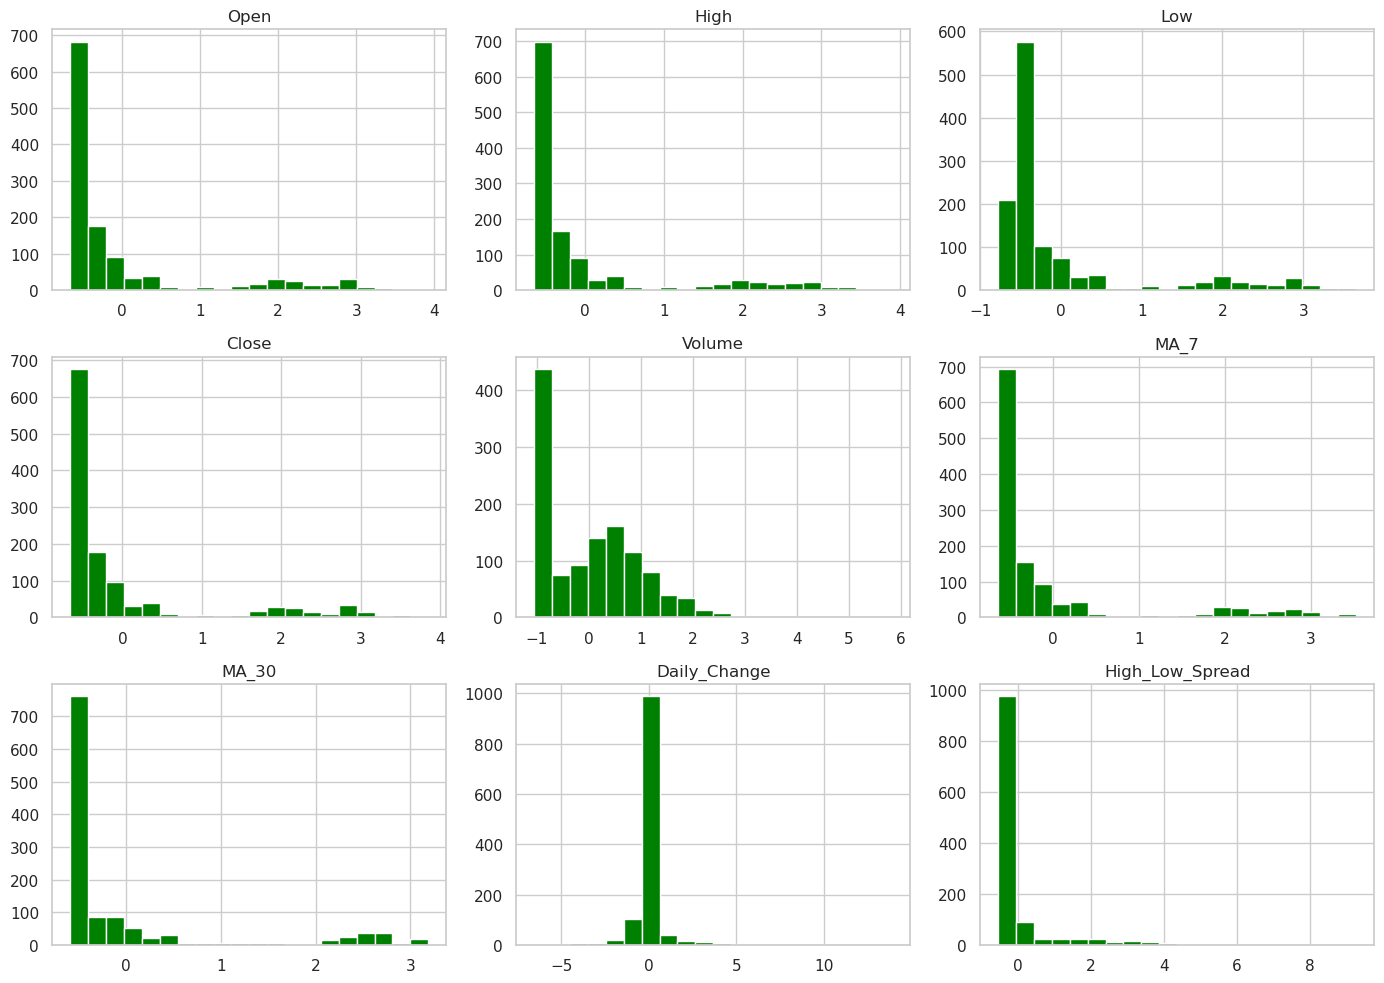

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size and style
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# Create histograms for all numerical columns, including new features
cocoa_df.hist(bins=20, figsize=(14, 10), layout=(3, 3), color='green')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


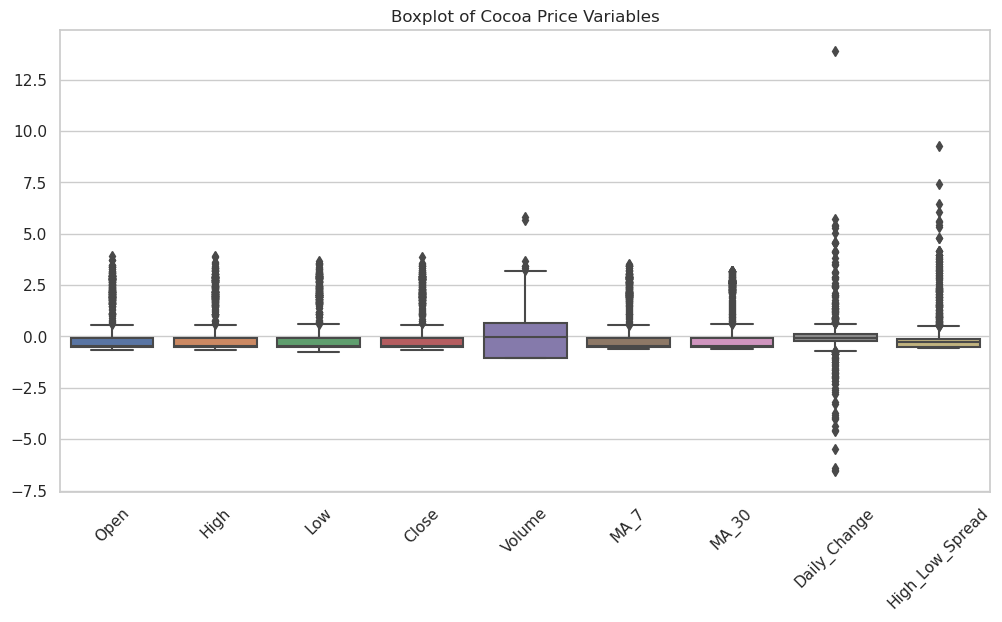

In [24]:
# Create boxplots for visualizing the spread and outliers
plt.figure(figsize=(12, 6))  # Set the size of the figure
sns.boxplot(data=cocoa_subset)  # Create boxplots
plt.title('Boxplot of Cocoa Price Variables')  # Title for the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

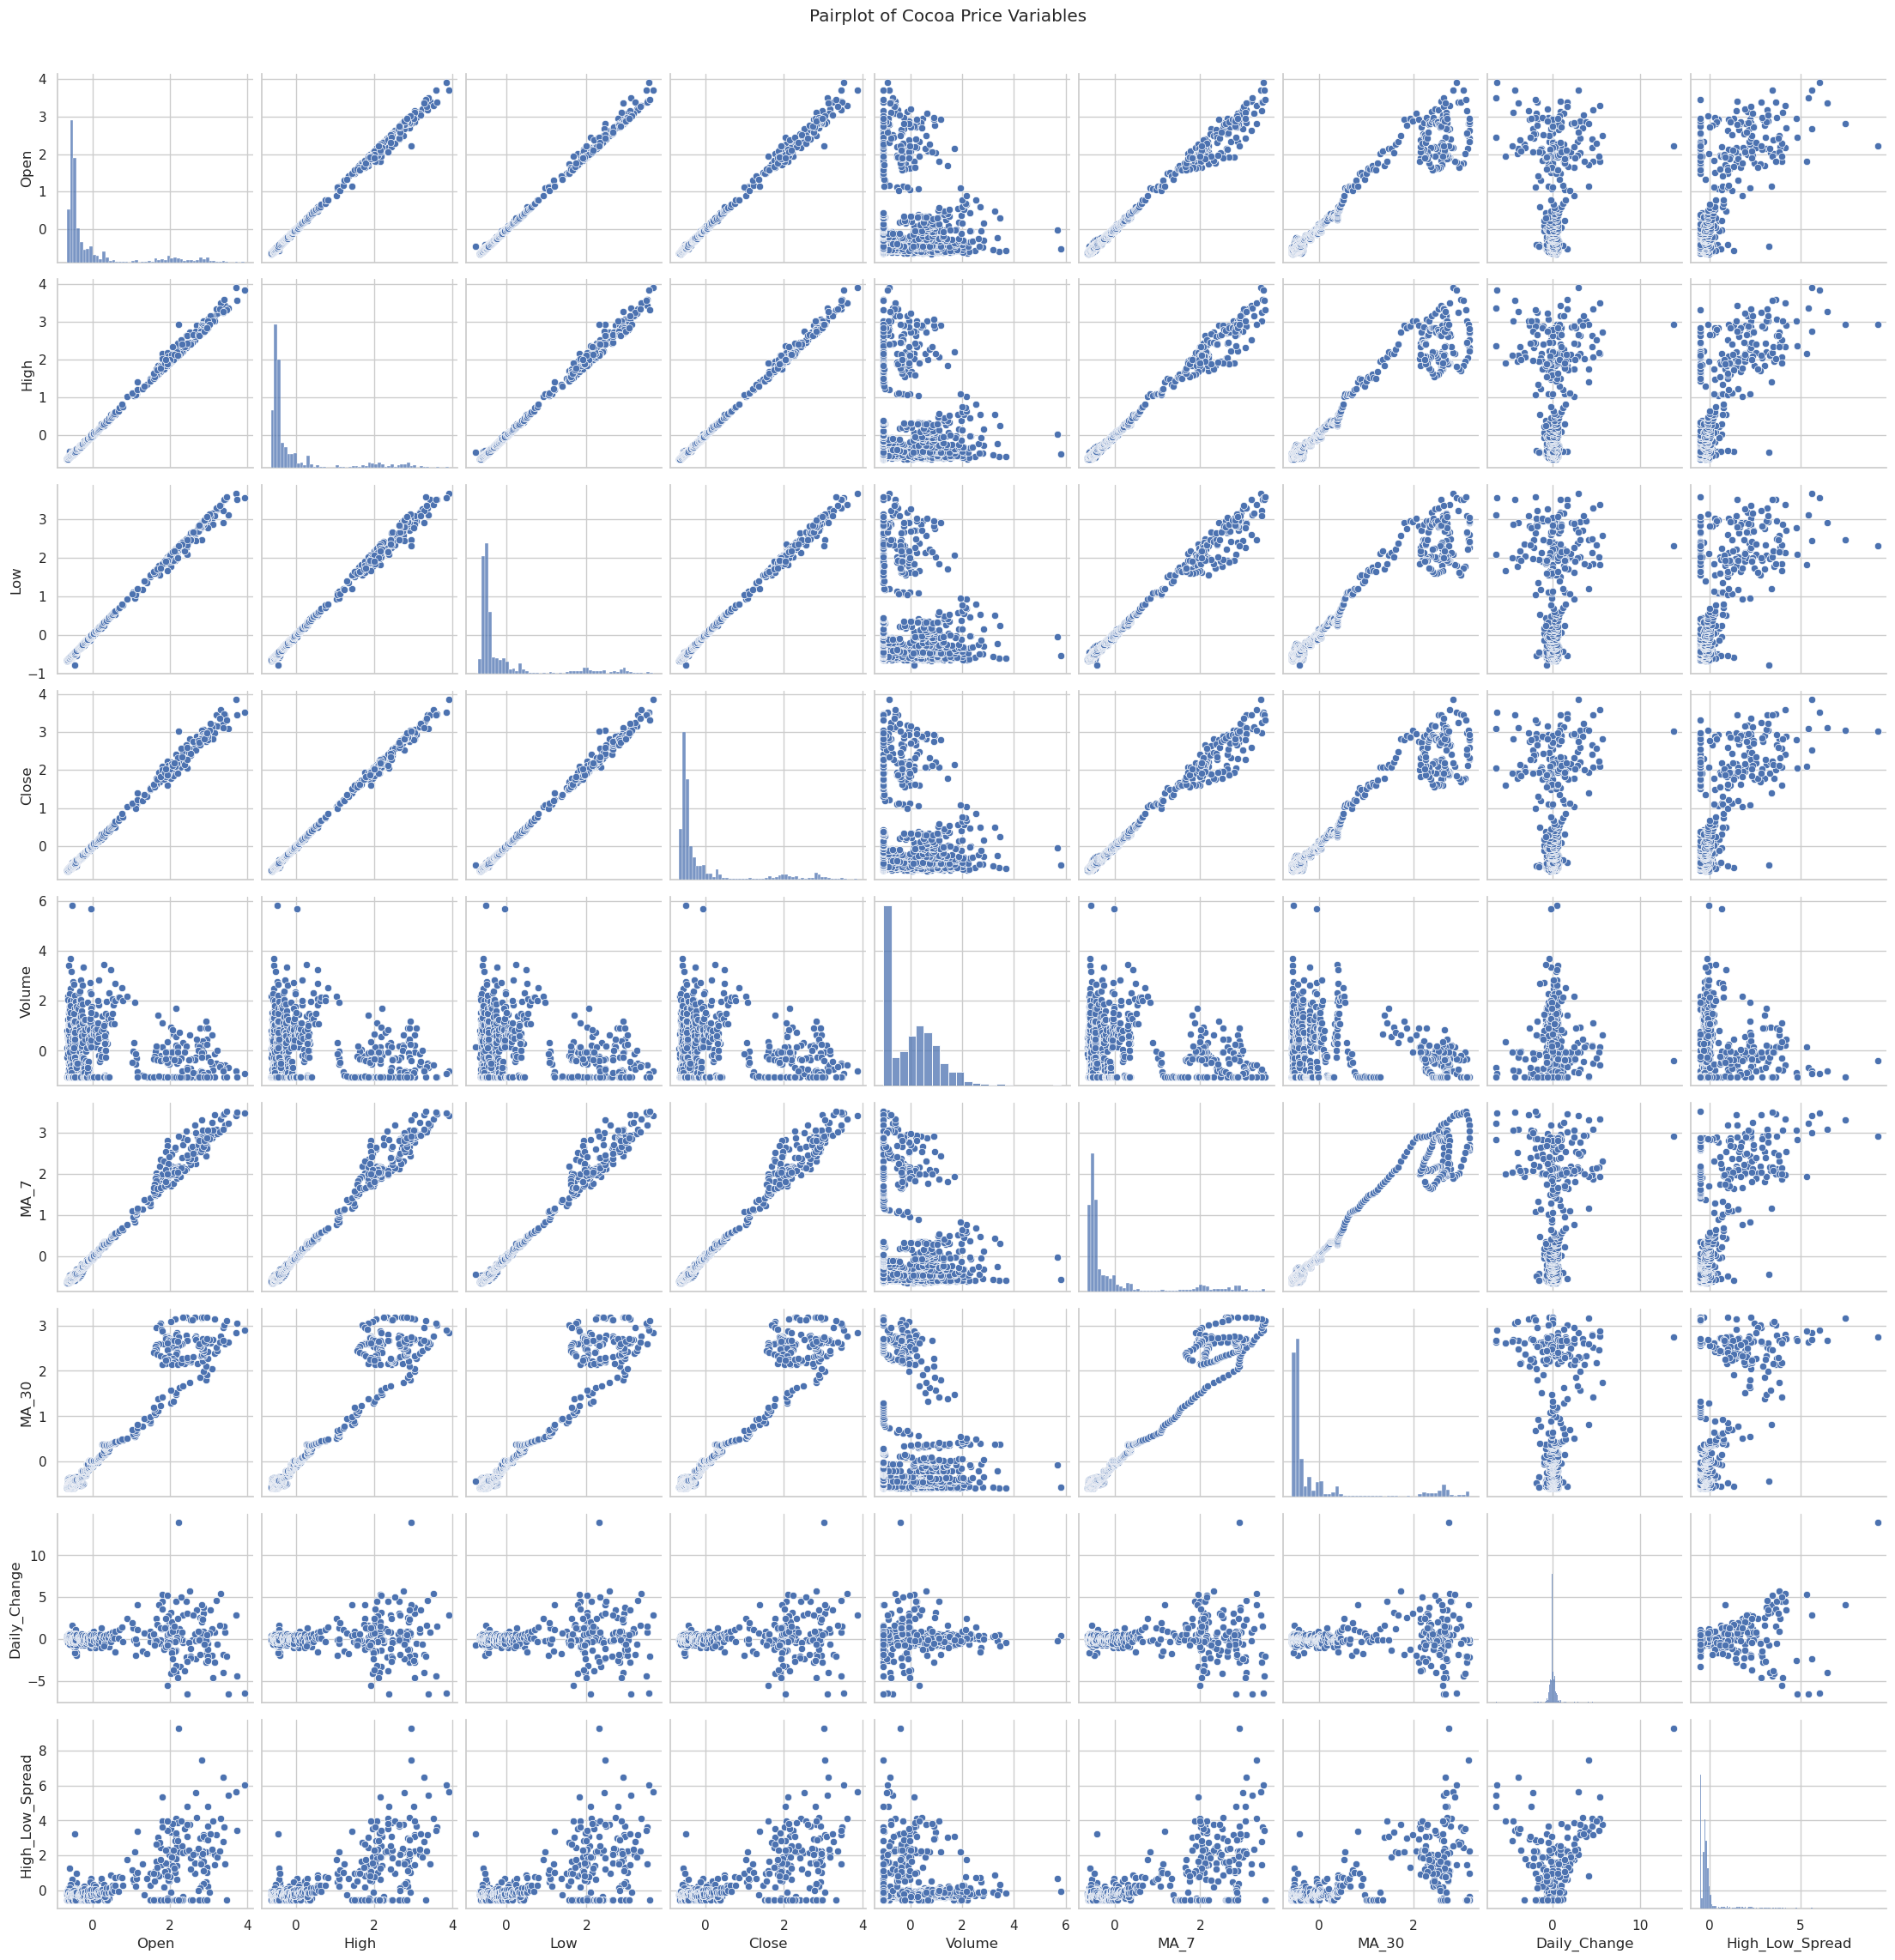

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Our relevent columns
#cocoa_columns = ["Open", "High", "Low", "Close", "Volume", "MA_7", "MA_30", "Daily_Change", "High_Low_Spread"]

# Create a subset of the dataframe with the relevant columns
#cocoa_subset = cocoa_df[cocoa_columns]

# Create pairplot for all combinations of variables
sns.pairplot(cocoa_df)  # Create pairplot
plt.suptitle('Pairplot of Cocoa Price Variables', y=1.02)  # Title of the plot
plt.show()  # Display the plot


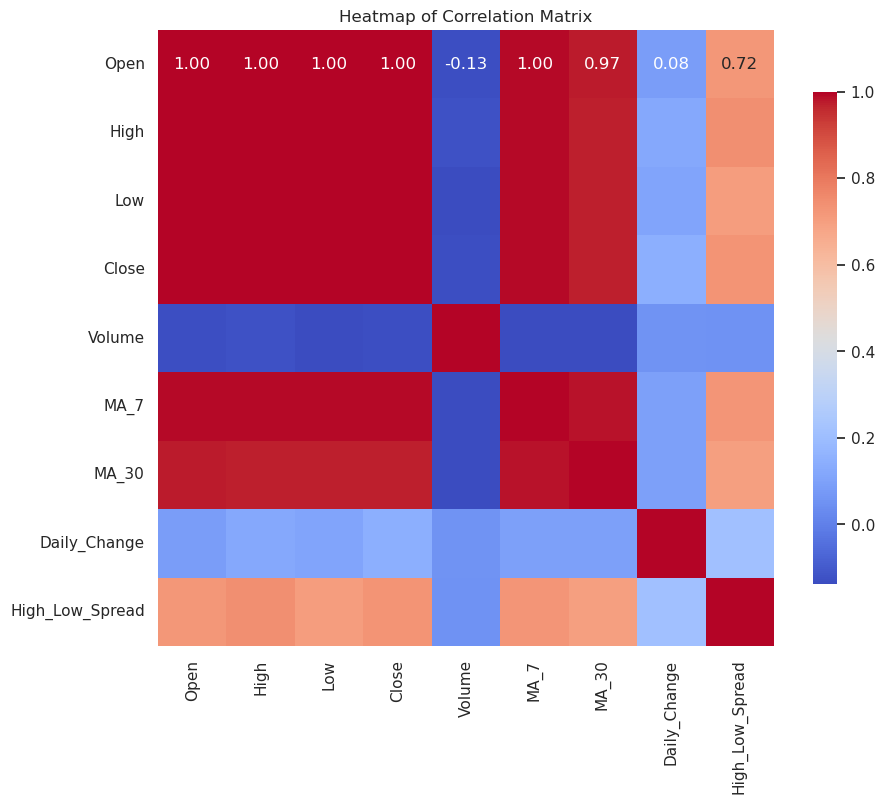

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Our relevent columns
cocoa_columns = ["Open", "High", "Low", "Close", "Volume", "MA_7", "MA_30", "Daily_Change", "High_Low_Spread"]

# Create a subset of the relevant columns
cocoa_subset = cocoa_df[cocoa_columns]

# Calculate the correlation matrix
correlation_matrix = cocoa_subset.corr()  # Calculate the correlation matrix

# Create a heatmap to visualize the correlation
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8})  # Create heatmap
plt.title('Heatmap of Correlation Matrix')  # Title of the plot
plt.show()  # Display the plot


### Interpretation of Heatmap of correlation matrix


**Strong relationships between certain variables:**

- Variables like 'Open', 'High', 'Low', and 'Close' are highly correlated (values close to 1). This indicates that market opening, closing, high, and low prices often move in tandem.
- The moving averages 'MA_7' and 'MA_30' are also strongly correlated with these price variables, which makes sense since moving averages are derived from the prices.

**Low correlation with 'Volume':**

- 'Volume' (traded volume) shows very low correlation with the prices (Open, Close, High, Low) and moving averages, suggesting that the volume of trades doesn't have a strong relationship with price movements in this dataset.

**'High_Low_Spread' correlation with prices:**

- The 'High_Low_Spread' (difference between high and low prices) is highly correlated with the price variables, as expected.

**Moderate correlation for 'Daily_Change':**

- 'Daily_Change' (the daily price change) shows only moderate correlation with other variables, indicating that daily fluctuations might be influenced by other factors beyond just the basic price levels.


**Implications for our clustering analysis:**

- We are looking to reduce the number of variables in the clustering model, we might consider excluding some of the highly correlated variables to avoid redundancy. For instance, we could choose just <code>'Close'</code> or <code>'Open'</code> instead of including all price variables.
- <code>'Volume'</code> might be worth keeping in our model because it seems to capture different information from the price-related variables.
In short, this heatmap helps us identify which variables might be redundant (due to high correlation) and which ones could provide unique insights for our clustering model.lustering model.

## <span id="top4">II. Clustering</span>

#### Evaluation method to find the number of cluster k

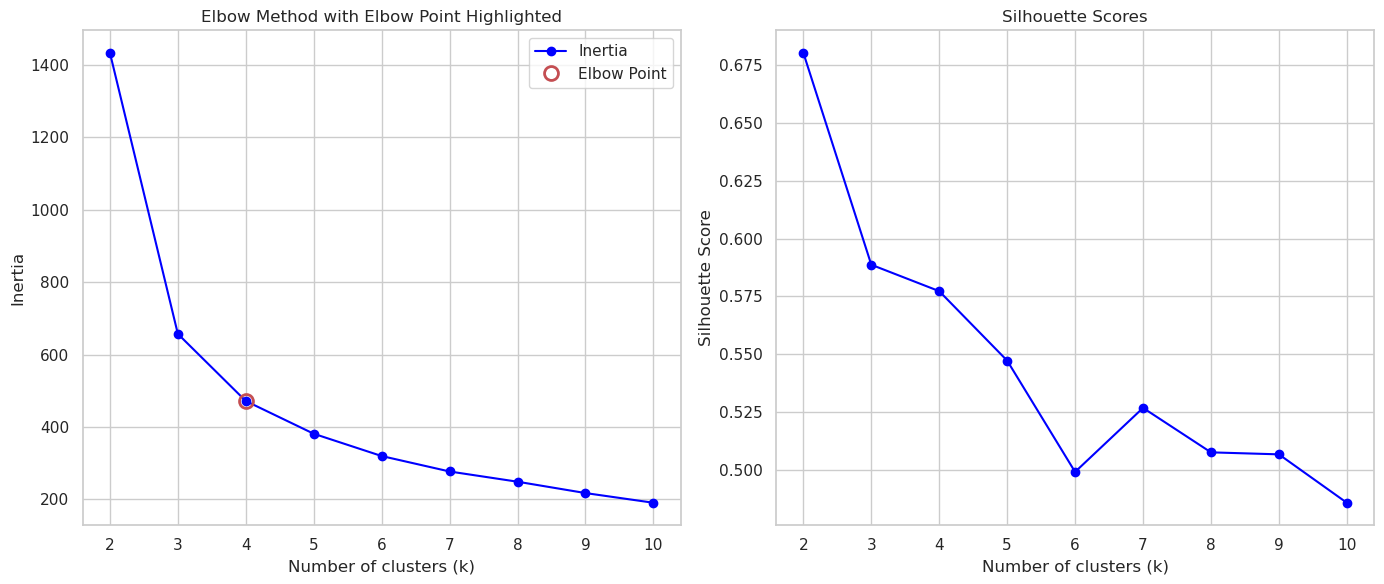

Elbow Point (optimal k): 4


In [27]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define the range of k values to test
k_values = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cocoa_df[["Open", "Close", "Volume"]])  

    # Append the inertia (which reflects the within-cluster variance)
    inertia.append(kmeans.inertia_)  # Store inertia (cost)
    
    # Calculate the silhouette score and append it
    silhouette_scores.append(silhouette_score(cocoa_df[["Open", "Close", "Volume"]], kmeans.labels_))

# Create a figure with 1 row and 2 columns for side-by-side plotting
plt.figure(figsize=(14, 6))  # Adjust the size for better visibility

# Plot the Silhouette scores
plt.subplot(1, 2, 2)  # First subplot in a 1x2 grid
plt.plot(k_values, silhouette_scores, marker='o', color='blue')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

# Elbow Point Calculation

# Find the Elbow point using the distance from a line that connects the first and last point
x_coords = np.arange(2, 11)  # k_values starts from 2
line_start = np.array([2, inertia[0]])  # First point (number of clusters = 2)
line_end = np.array([10, inertia[-1]])  # Last point (number of clusters = 10)

# Calculate the vector based on the line
line_vec = line_end - line_start
line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))  # Normalize the vector

# Calculate distances of each point to the line
distances = []
for i in range(len(inertia)):
    point = np.array([x_coords[i], inertia[i]])
    point_vec = point - line_start
    proj_of_point_onto_line = line_start + line_vec_norm * np.dot(point_vec, line_vec_norm)
    # Euclidean distance formula
    distance = np.sqrt(np.sum((proj_of_point_onto_line - point)**2))
    distances.append(distance)

# The index of the elbow point is the one with the maximum distance to the line
elbow_point = np.argmax(distances) + 2  # Add 2 because we started with k = 2

# Plot the Elbow method again with the elbow point highlighted
plt.subplot(1, 2, 1)  # Second subplot in a 1x2 grid
plt.plot(k_values, inertia, marker='o', color='blue', label='Inertia')
plt.plot(elbow_point, inertia[elbow_point - 2], 'ro', markersize=10, markerfacecolor='none', markeredgewidth=2, label='Elbow Point')  # Red circle with no fill
plt.title('Elbow Method with Elbow Point Highlighted')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)

# Adjust layout to ensure plots are not overlapping
plt.tight_layout()

# Show both plots side by side
plt.show()

print(f"Elbow Point (optimal k): {elbow_point}")


#### Comparison of the two methods:

- Elbow Method indicates that 4 clusters is optimal, as this is the point at which inertia no longer decreases significantly.
Silhouette Score is highest for 2 clusters, but continues to decrease, reaching a still reasonable score for 3 clusters (≈ 0.60) and 4 clusters (≈ 0.55).

**Conclusion** :

- The Silhouette Score and the elbow method don't exactly point to the same optimal number of clusters in this case. If we are looking for a very clear separation between clusters, the Silhouette Score might suggest <code>2 clusters</code>.
 
- However, if we are looking for a compromise between separation and variance explanation (as in the elbow method), <code>4 clusters</code> seems a good choice, as it is marked by the “elbow” and the Silhouette Score is still relatively acceptable (≈ 0.55).
In this context, it would be interesting to analyze the clusters in more detail to see whether the 4 cluster solution reveals significant groups in our data. (Sharma, 2019)

### <span id="top5"> 1. Implementation of some algorithms</span>

### K-means Clustering

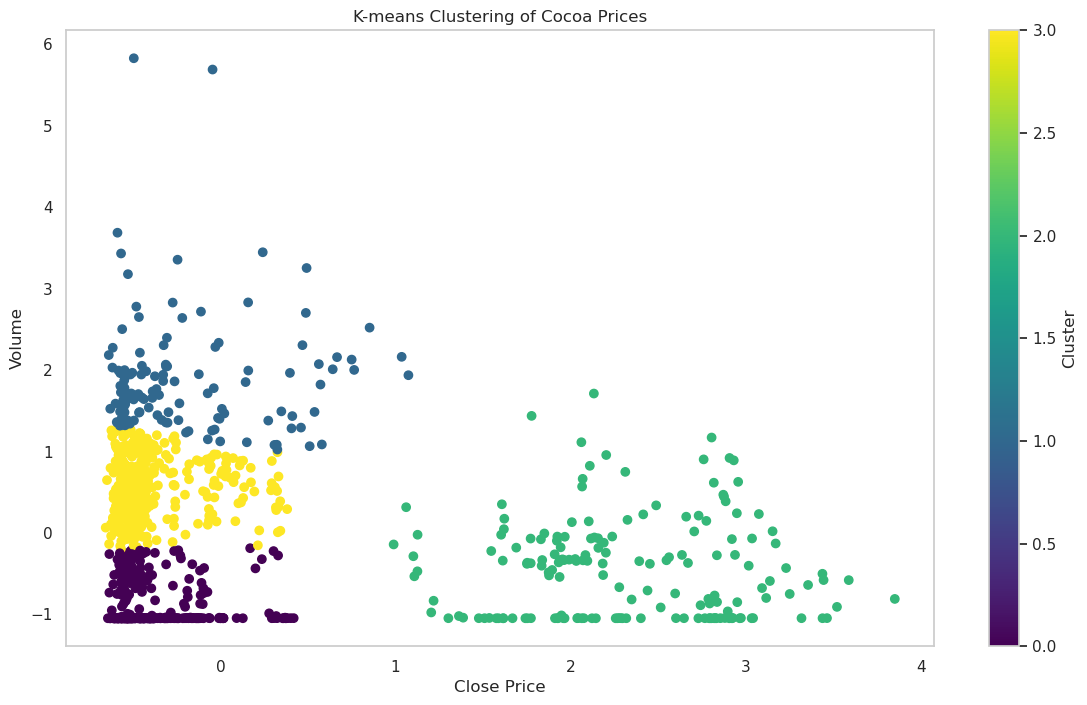

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Select relevant features for clustering
features = cocoa_df[["Close", "Open", "Volume"]]

# 2. Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Apply K-means algorithm
k = 4  # Choosing 4 clusters for example
kmeans = KMeans(n_clusters=k, random_state=42)
cocoa_df['Cluster'] = kmeans.fit_predict(scaled_features)

# Plotting the clustering results
plt.figure(figsize=(14, 8))
plt.scatter(cocoa_df['Close'], cocoa_df['Volume'], c=cocoa_df['Cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering of Cocoa Prices')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [39]:
import plotly.graph_objects as go
from sklearn.cluster import KMeans

# Apply the KMeans model for the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cocoa_df['cluster'] = kmeans.fit_predict(cocoa_df[['Open', 'Close', 'Volume']])

# Define colors for each cluster
colors = ['blue', 'green', 'red', 'orange']

# Create dynamic 3D figure
fig = go.Figure()

# Add points for each cluster
for cluster in range(4):
    fig.add_trace(go.Scatter3d(
        x=cocoa_df.loc[cocoa_df['cluster'] == cluster, 'Open'],
        y=cocoa_df.loc[cocoa_df['cluster'] == cluster, 'Close'],
        z=cocoa_df.loc[cocoa_df['cluster'] == cluster, 'Volume'],
        mode='markers',
        marker=dict(size=5, color=colors[cluster], opacity=0.8),
        name=f'Cluster {cluster}'
    ))

# AAdd centroids
centroids = kmeans.cluster_centers_
fig.add_trace(go.Scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(size=10, color='black', symbol='x'),
    name='Centroids'
))

# Adjust axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='Open',
        yaxis_title='Close',
        zaxis_title='Volume'
    ),
    title="3D visualization of clusters (interactive)",
    showlegend=True
)

# Plotting the clustering results
fig.show()

### DBSCAN Clustering

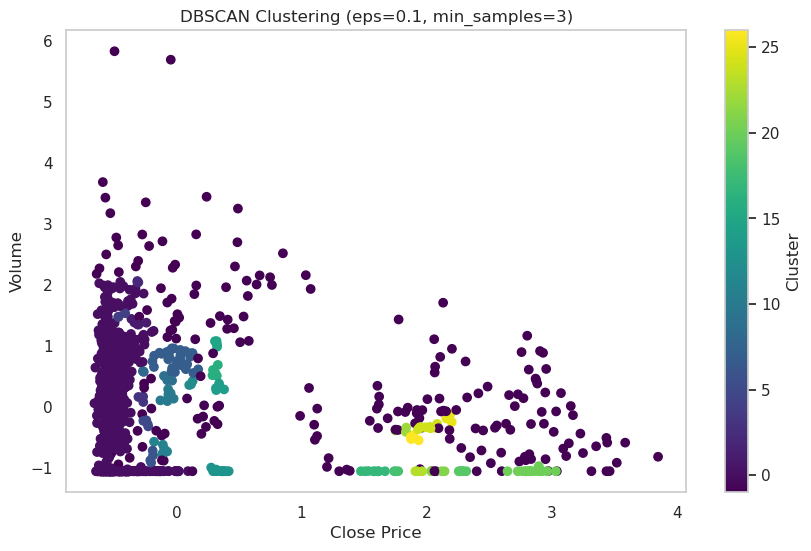

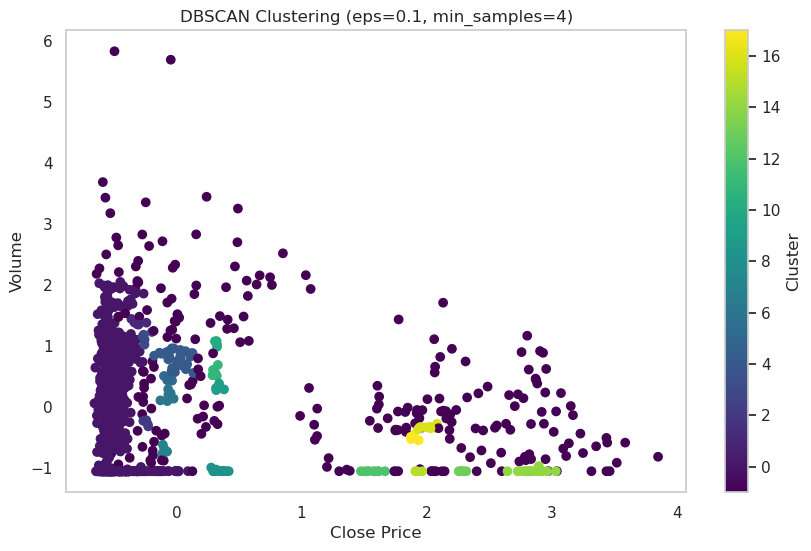

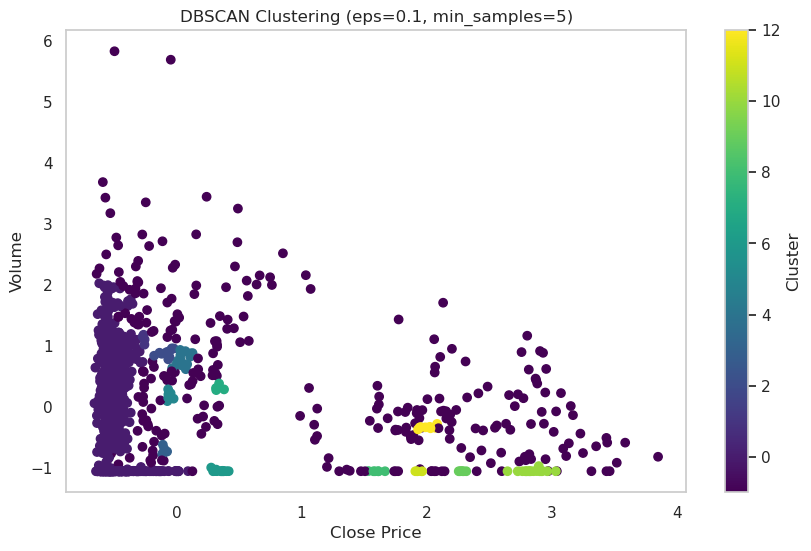

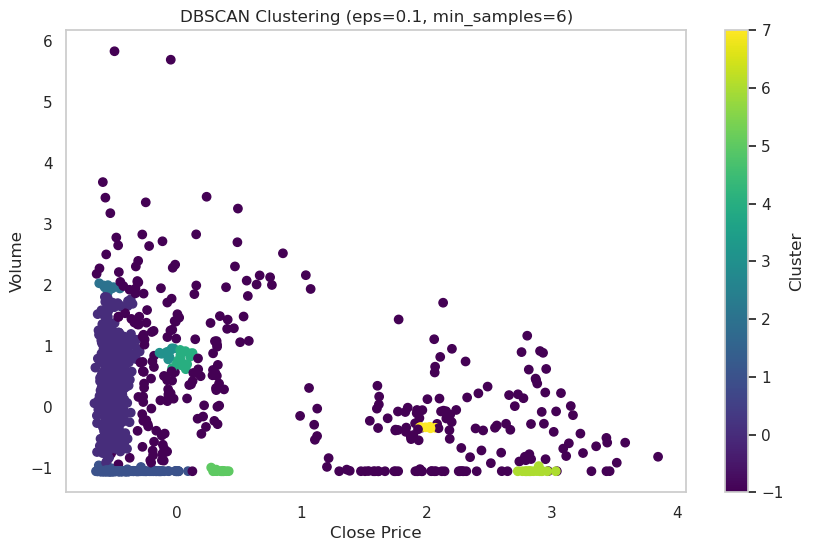

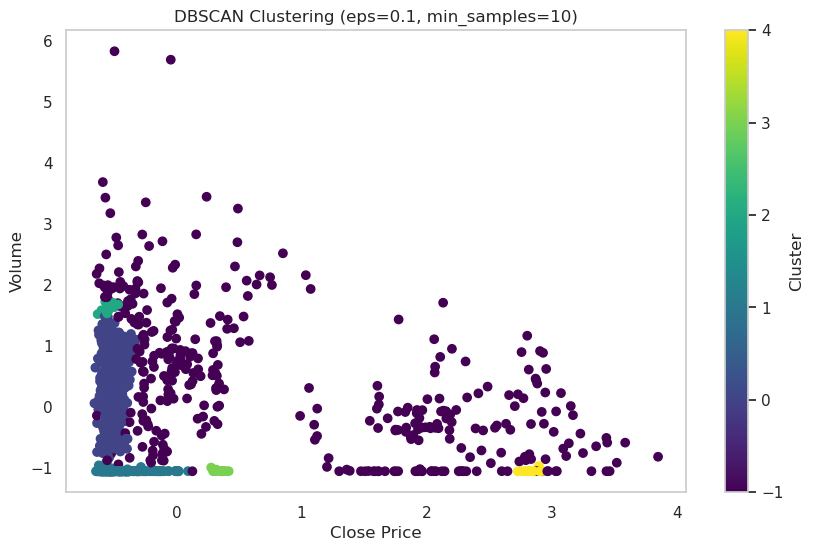

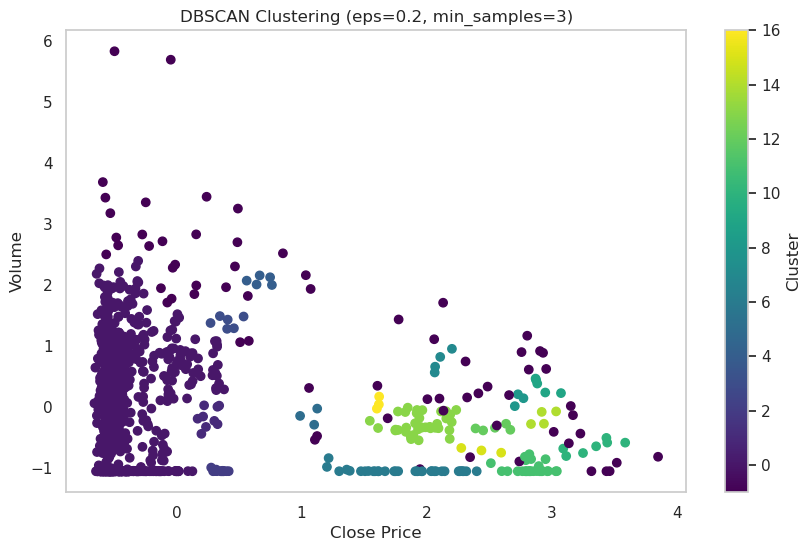

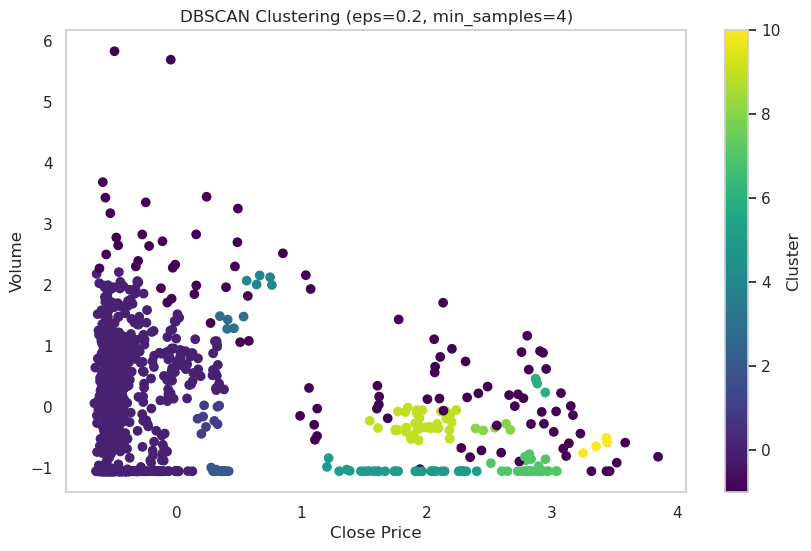

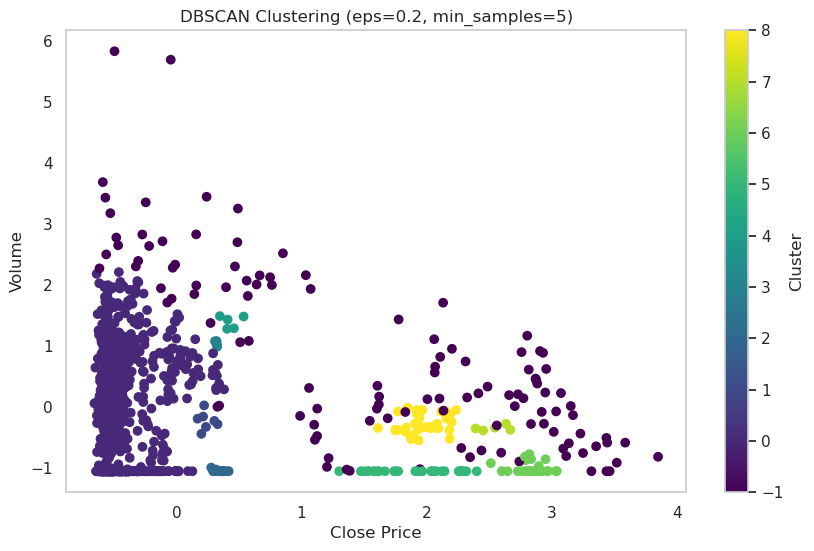

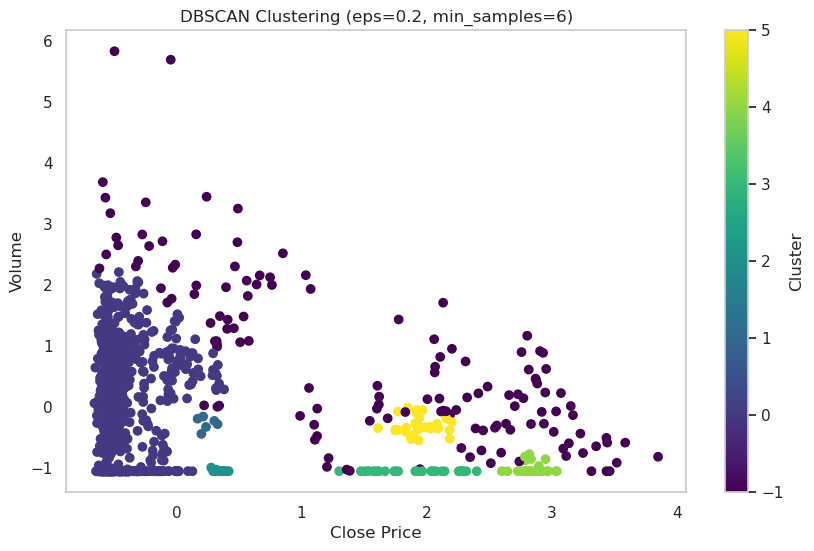

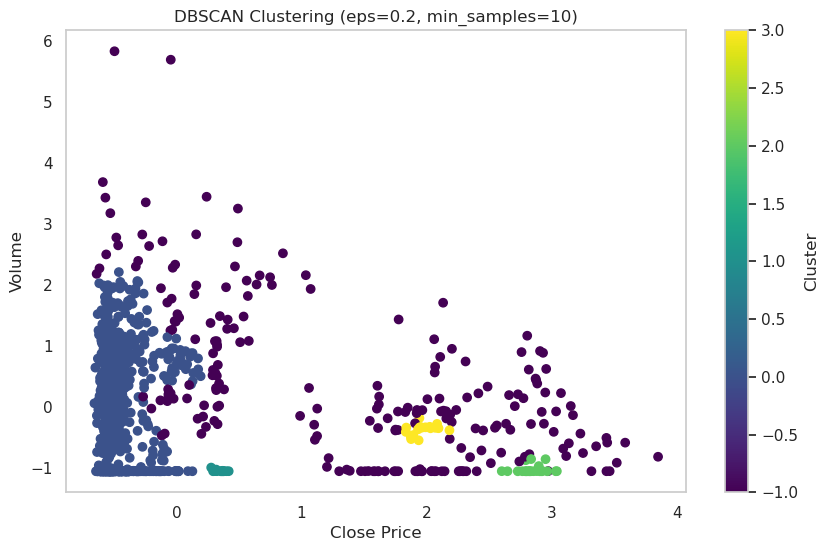

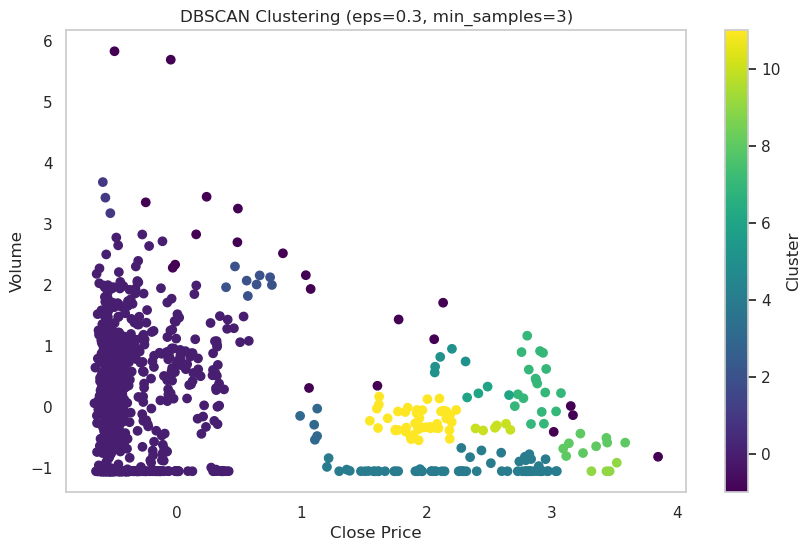

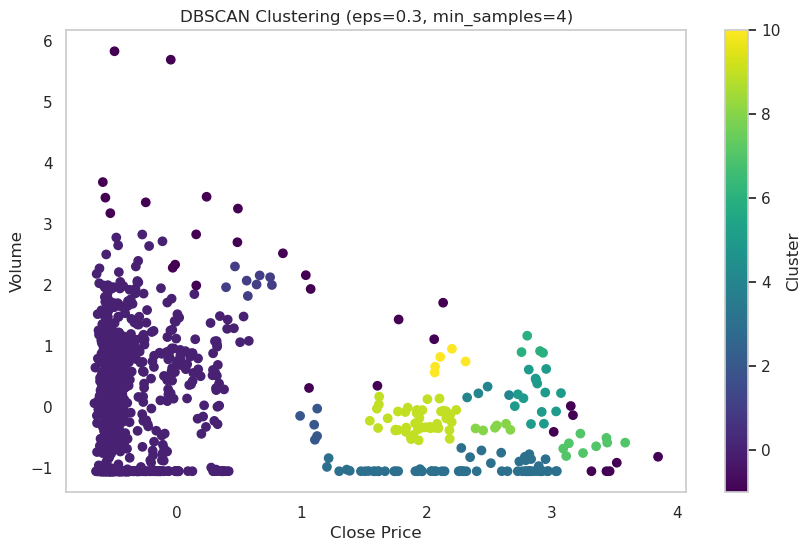

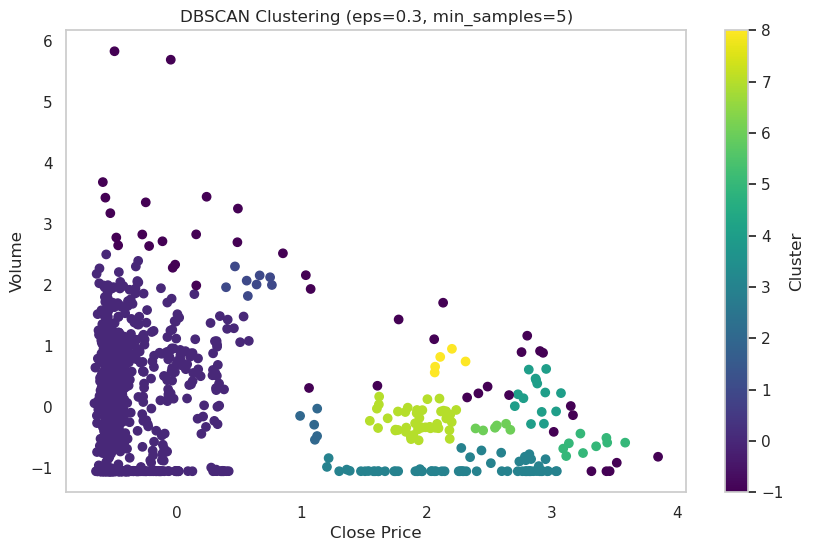

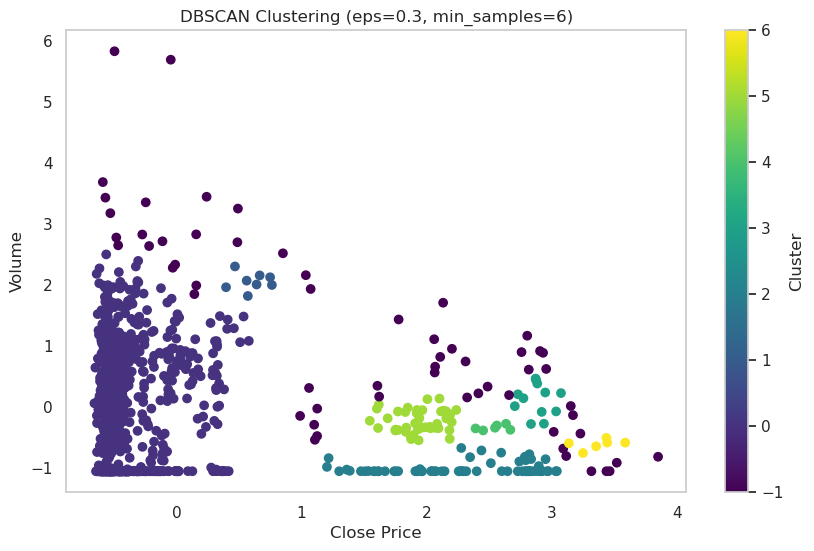

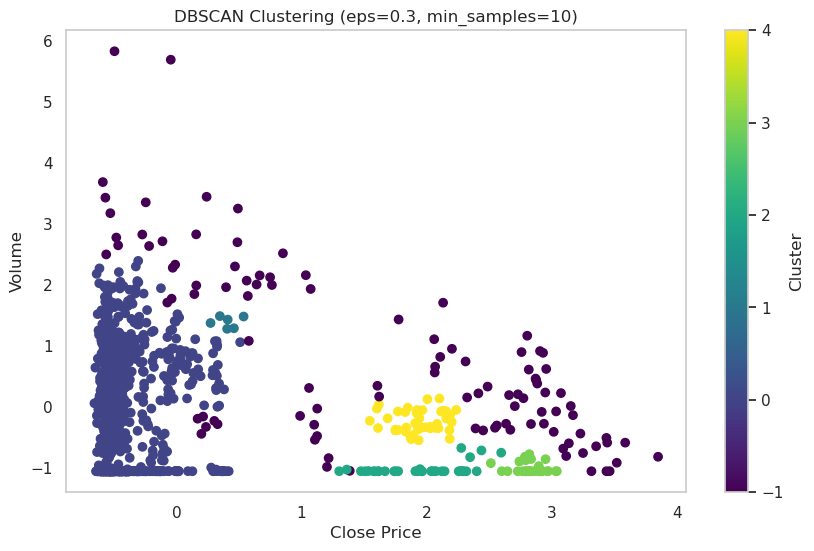

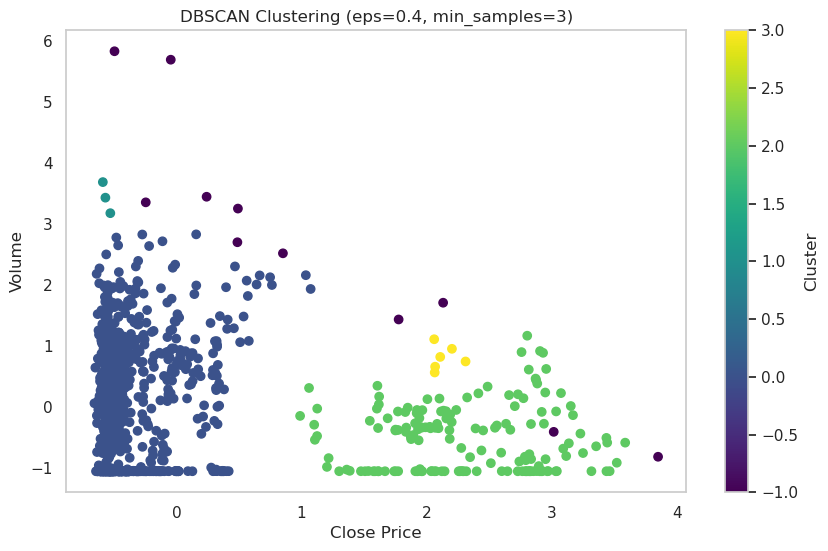

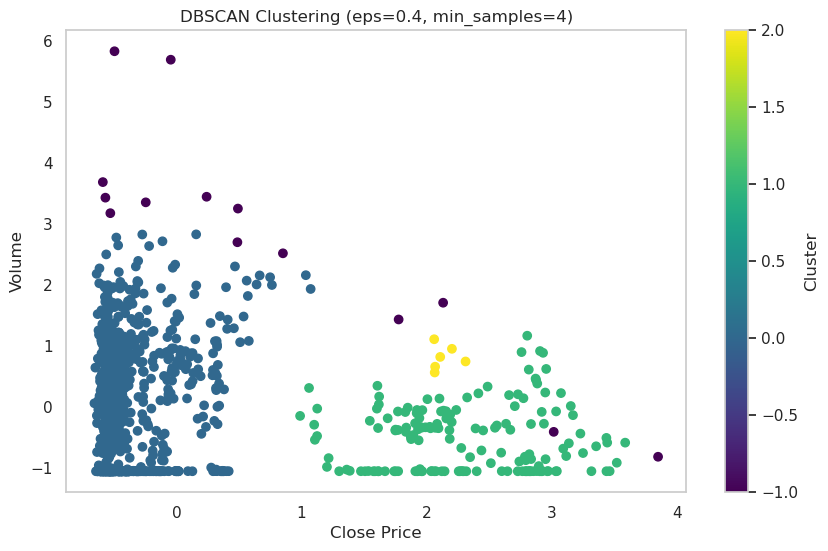

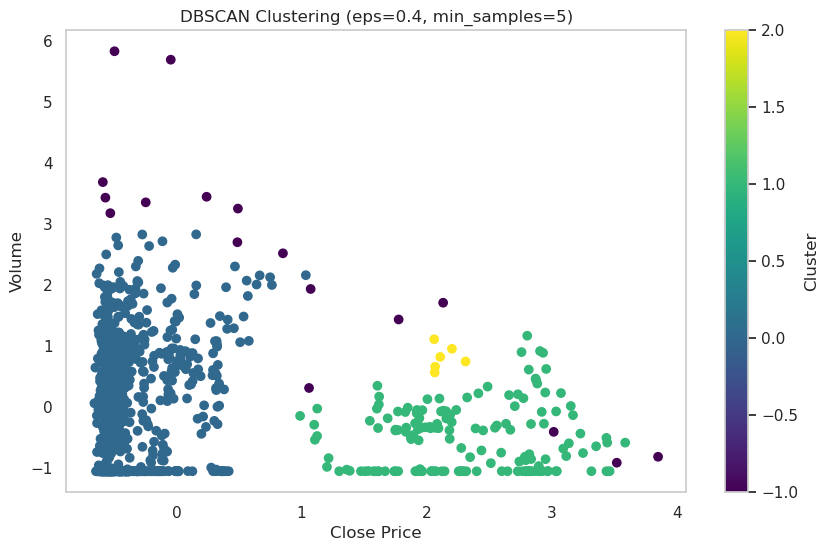

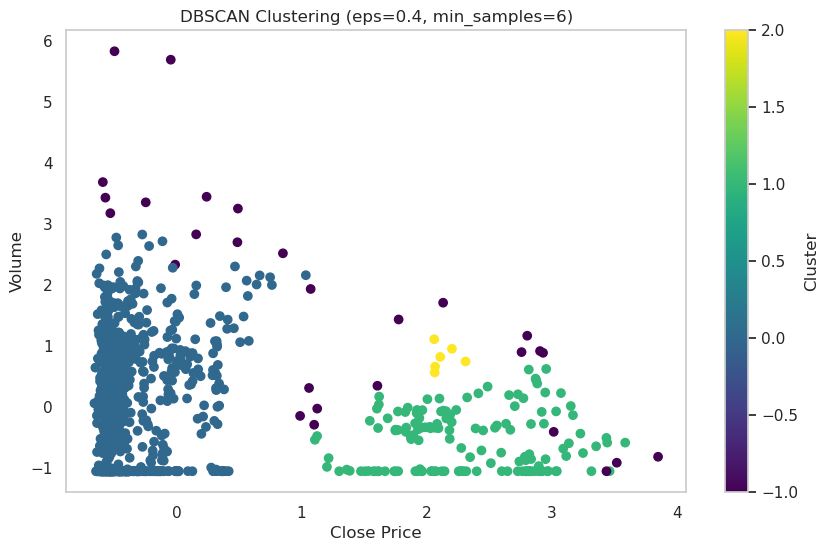

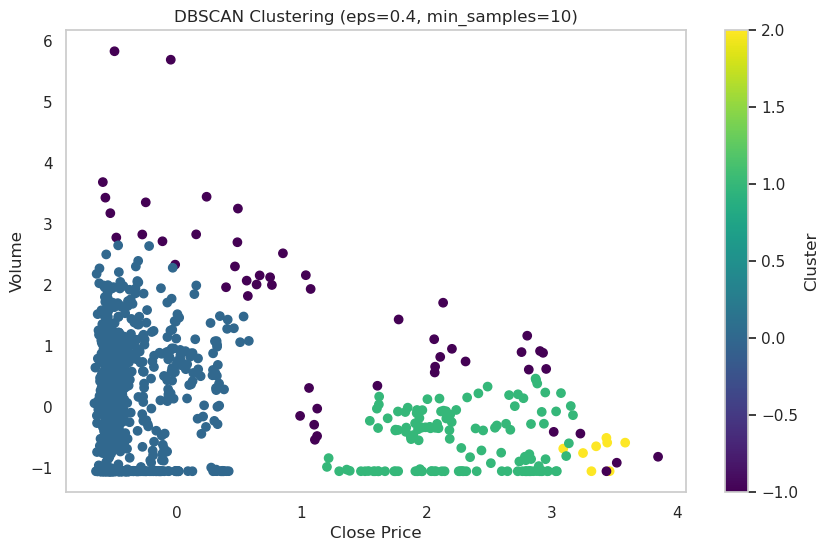

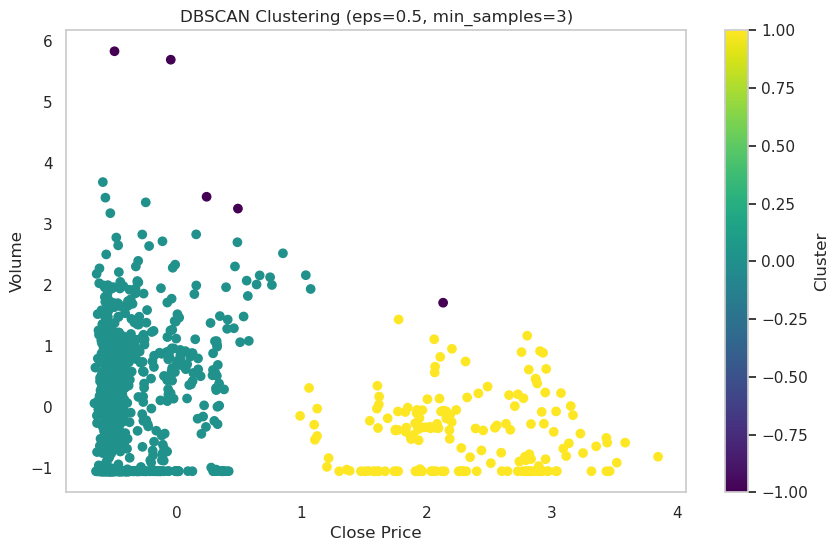

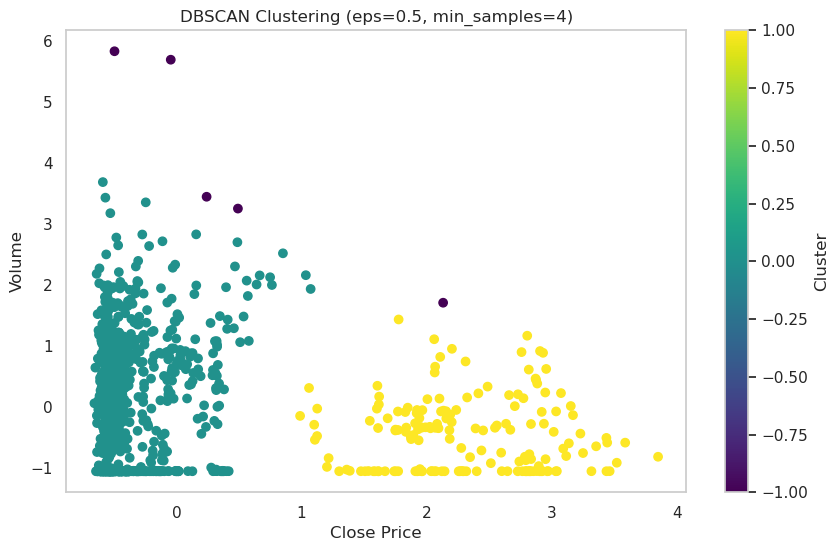

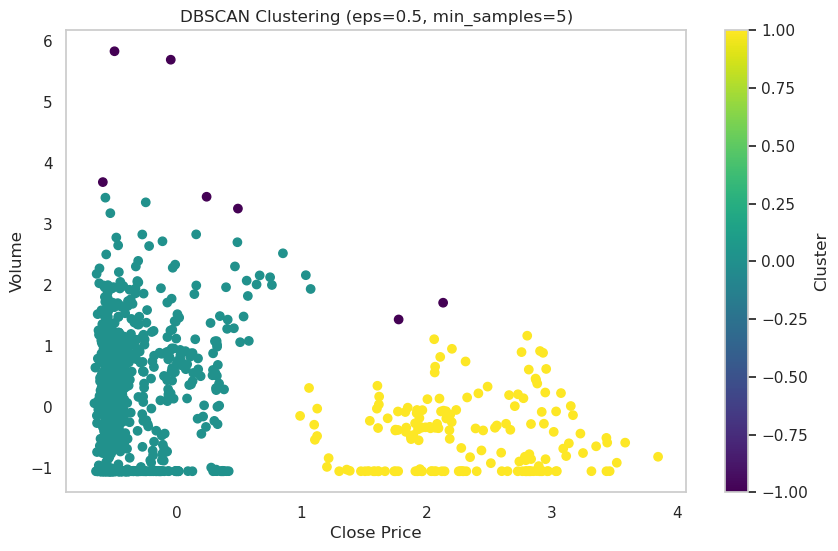

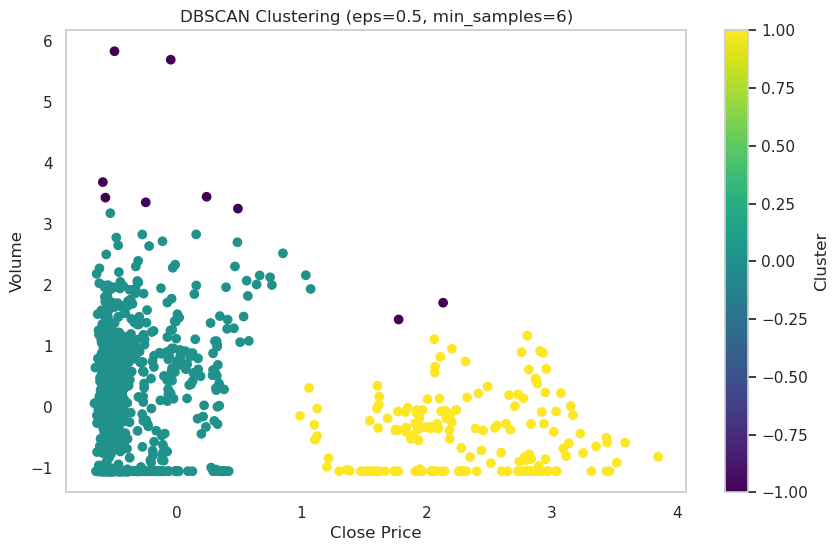

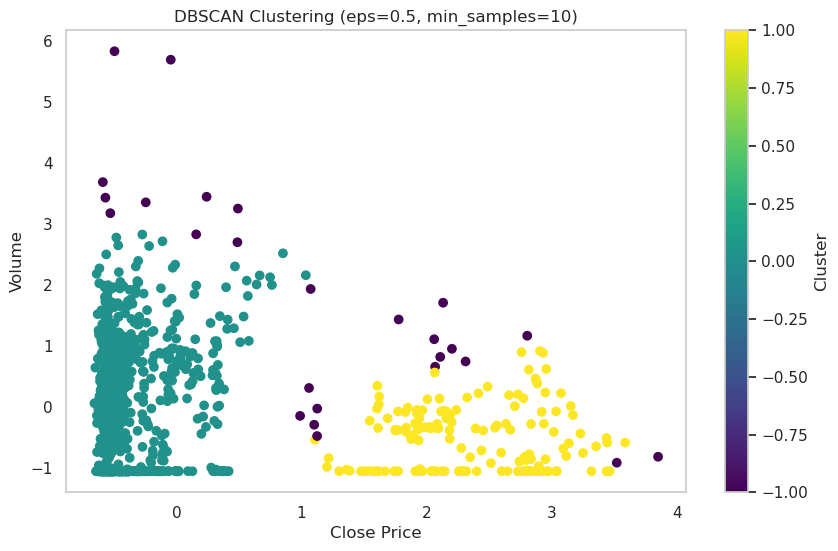

In [40]:
# Choosing values for eps and min_samples
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [3, 4, 5, 6, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cocoa_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

        # Plotting the results for each combination
        plt.figure(figsize=(10, 6))
        plt.scatter(cocoa_df['Close'], cocoa_df['Volume'], c=cocoa_df['DBSCAN_Cluster'], cmap='viridis', marker='o')
        plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
        plt.xlabel('Close Price')
        plt.ylabel('Volume')
        plt.colorbar(label='Cluster')
        plt.grid()
        plt.show()

### Gaussian Mixture Models (GMM)

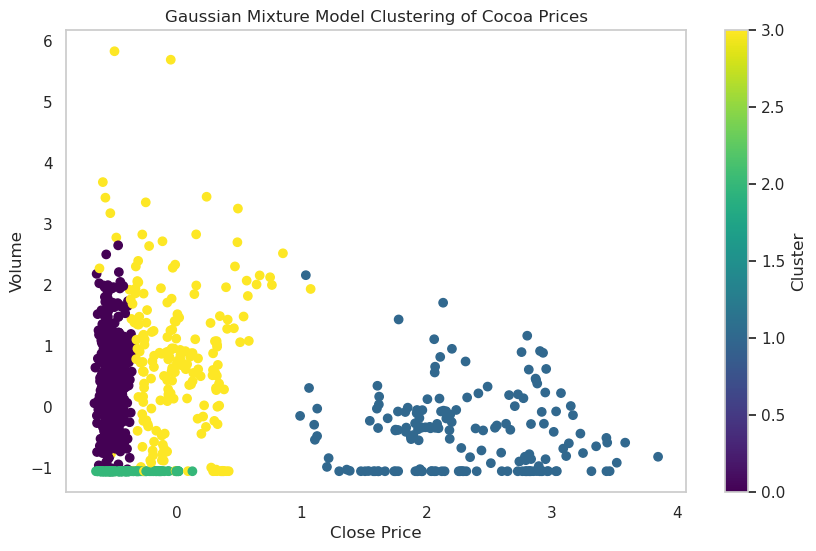

In [41]:
from sklearn.mixture import GaussianMixture

# Fit the GMM
gmm = GaussianMixture(n_components=4, random_state=42)  # Use the number of clusters found from K-means
gmm.fit(scaled_features)
cocoa_df['GMM_Cluster'] = gmm.predict(scaled_features)

# Plotting the GMM clustering results
plt.figure(figsize=(10, 6))
plt.scatter(cocoa_df['Close'], cocoa_df['Volume'], c=cocoa_df['GMM_Cluster'], cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering of Cocoa Prices')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


### Fuzzy-c-means

In [42]:
# Install this library before starting Fuzzy c-means clustering
#!pip install fuzzy-c-means

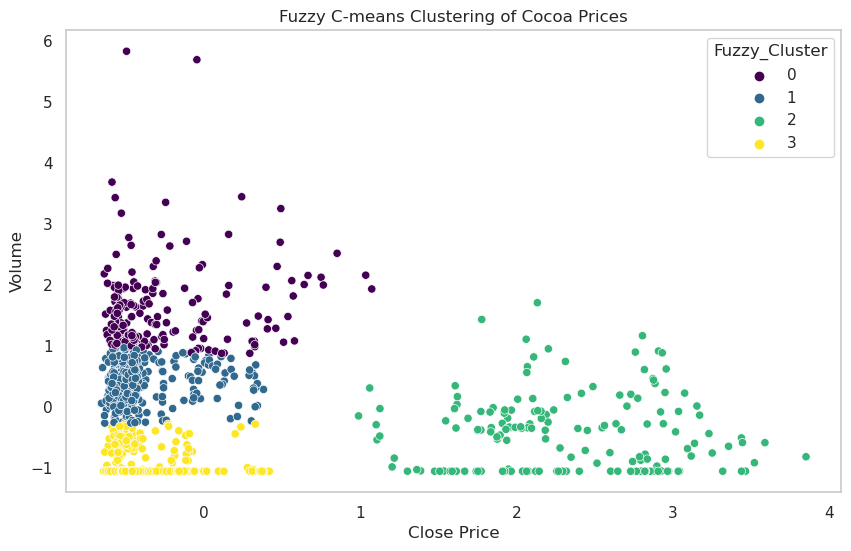

In [43]:
from fcmeans import FCM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Select relevant features for clustering
features = cocoa_df[["Close", "Open", "Volume"]].values  # Convert to numpy array

# 2. Initialize the FCM model
fcm = FCM(n_clusters=4, random_state=42)

# 3. Fit the model
fcm.fit(features)

# 4. Predict the clusters and assign them to the dataframe
cocoa_df['Fuzzy_Cluster'] = fcm.predict(features)

# 5. Plotting the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cocoa_df['Close'], y=cocoa_df['Volume'], hue=cocoa_df['Fuzzy_Cluster'], palette='viridis', marker='o')
plt.title('Fuzzy C-means Clustering of Cocoa Prices')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.grid()
plt.show()


### K-medoids 

In [47]:
#!pip install pyclustering

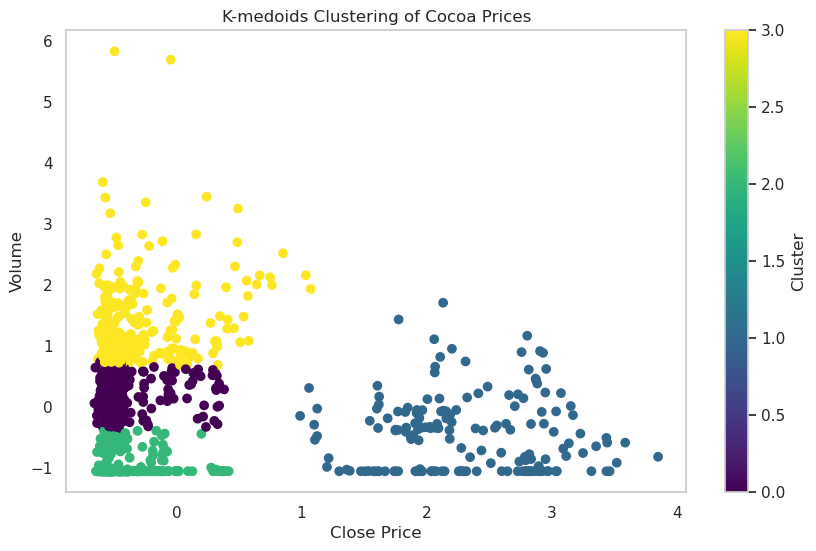

In [48]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 1. Relevant features for clustering
features = cocoa_df[["Close", "Open", "Volume"]].values  # Convert to numpy array

# 2. Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Initial medoids (randomly select indices from data points)
initial_medoids = [0, 100, 500, 1000]  # Example indices, we can select more randomly

# 4. Calculate the distance matrix
distance_matrix = calculate_distance_matrix(scaled_features)

# 5. Apply K-medoids algorithm
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# Get the clusters and medoids
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# 6. Assign the cluster labels to the dataset
cluster_labels = np.zeros(len(scaled_features))  # Initialize with zeros
for cluster_id, cluster in enumerate(clusters):
    for index in cluster:
        cluster_labels[index] = cluster_id

cocoa_df['KMedoids_Cluster'] = cluster_labels

# 7. Plotting the K-medoids clustering results
plt.figure(figsize=(10, 6))
plt.scatter(cocoa_df['Close'], cocoa_df['Volume'], c=cocoa_df['KMedoids_Cluster'], cmap='viridis', marker='o')
plt.title('K-medoids Clustering of Cocoa Prices')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


### Hierarchical clustering

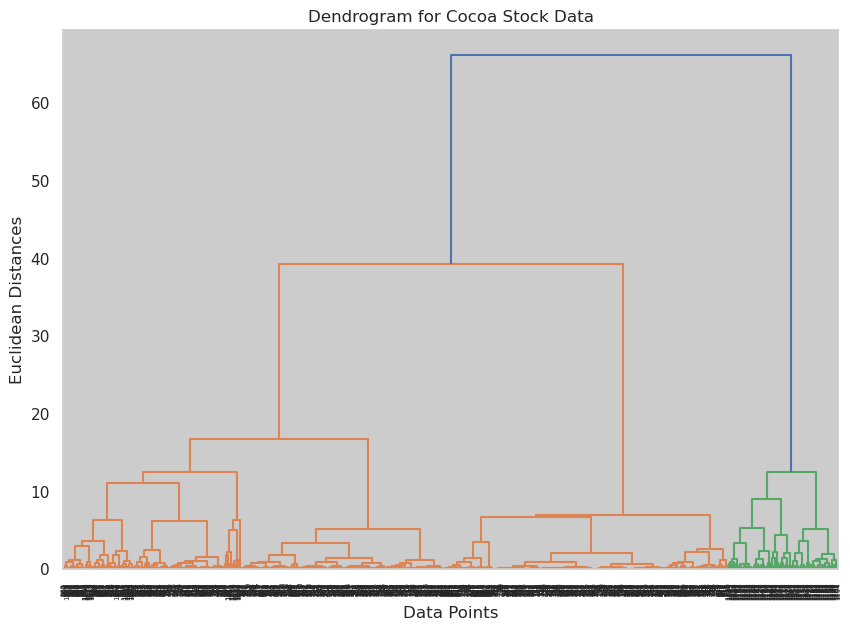

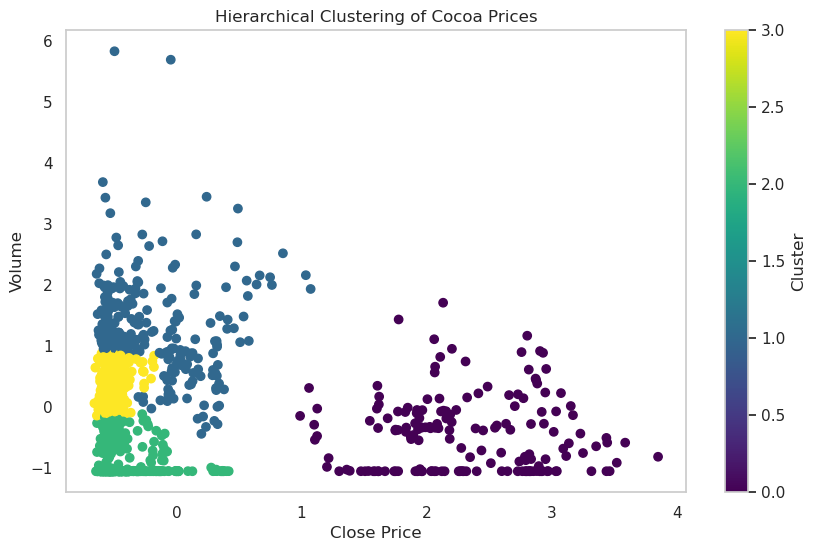

In [49]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Relevant features for clustering
features = cocoa_df[["Close", "Open", "Volume"]].values  # Convert to numpy array

# 2. Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 3. Generate the linkage matrix for the dendrogram
linked = linkage(scaled_features, method='ward')

# 4. Plotting the dendrogram to visualize the hierarchy
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Cocoa Stock Data')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distances')
plt.show()

# 5. Apply Agglomerative Clustering based on the number of clusters (e.g., 4 clusters in our case)
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
cocoa_df['Hierarchical_Cluster'] = hierarchical_cluster.fit_predict(scaled_features)

# 6. Plot the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(cocoa_df['Close'], cocoa_df['Volume'], c=cocoa_df['Hierarchical_Cluster'], cmap='viridis', marker='o')
plt.title('Hierarchical Clustering of Cocoa Prices')
plt.xlabel('Close Price')
plt.ylabel('Volume')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


In [61]:
#!pip install scikit-fuzzy
#!pip install fcmeans
#!pip install scikit-learn-extra

### <span id="top6">2. Comparison of clustering algorithms using silhouette score and Davies-Bouldin index</span>

In [62]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import skfuzzy as fuzz
from sklearn_extra.cluster import KMedoids
import numpy as np

# Features
features = cocoa_df[["Close", "Open", "Volume"]]

# Dictionary to store results
results = {}

# 1. KMeans
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust n_clusters
kmeans_labels = kmeans.fit_predict(features)
results['KMeans'] = {
    'Silhouette Score': silhouette_score(features, kmeans_labels),
    'Davies-Bouldin Index': davies_bouldin_score(features, kmeans_labels)
}

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(features)
if len(np.unique(dbscan_labels)) > 1:  # Creates more than 1 cluster
    results['DBSCAN'] = {
        'Silhouette Score': silhouette_score(features, dbscan_labels),
        'Davies-Bouldin Index': davies_bouldin_score(features, dbscan_labels)
    }

# 3. Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)  # Adjust n_components
gmm_labels = gmm.fit_predict(features)
results['Gaussian Mixture'] = {
    'Silhouette Score': silhouette_score(features, gmm_labels),
    'Davies-Bouldin Index': davies_bouldin_score(features, gmm_labels)
}

# 4. Fuzzy C-Means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features.T, 4, 2, error=0.005, maxiter=1000, init=None)  # Adjust number of clusters
fcm_labels = np.argmax(u, axis=0)
results['Fuzzy C-Means'] = {
    'Silhouette Score': silhouette_score(features, fcm_labels),
    'Davies-Bouldin Index': davies_bouldin_score(features, fcm_labels)
}

# 5. K-Medoids
kmedoids = KMedoids(n_clusters=4, random_state=42)  # Adjust n_clusters
kmedoids_labels = kmedoids.fit_predict(features)
results['K-Medoids'] = {
    'Silhouette Score': silhouette_score(features, kmedoids_labels),
    'Davies-Bouldin Index': davies_bouldin_score(features, kmedoids_labels)
}

# 6. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(features)
results['Hierarchical'] = {
    'Silhouette Score': silhouette_score(features, hierarchical_labels),
    'Davies-Bouldin Index': davies_bouldin_score(features, hierarchical_labels)
}

# Display the results
for algorithm, scores in results.items():
    print(f"{algorithm}:")
    print(f"  Silhouette Score: {scores['Silhouette Score']}")
    print(f"  Davies-Bouldin Index: {scores['Davies-Bouldin Index']}")
    print()

KMeans:
  Silhouette Score: 0.5772675178615696
  Davies-Bouldin Index: 0.6519144733504185

DBSCAN:
  Silhouette Score: 0.6499886590644982
  Davies-Bouldin Index: 0.6853837536824688

Gaussian Mixture:
  Silhouette Score: 0.3966283738082284
  Davies-Bouldin Index: 1.3335588259708666

Fuzzy C-Means:
  Silhouette Score: 0.5510082441236933
  Davies-Bouldin Index: 0.6699908738863559

K-Medoids:
  Silhouette Score: 0.5268670235201744
  Davies-Bouldin Index: 0.6762802001640206

Hierarchical:
  Silhouette Score: 0.5113241776883986
  Davies-Bouldin Index: 0.7541542450163274



### <span id="top7">3. Comparative Analysis of Models</span>:

**K-Means:**

- Silhouette Score: 0.5773 → A fairly good score, indicating that the clusters are well-formed and separated.
- DBI: 0.6519 → A good Davies-Bouldin Index, which indicates good cluster separation.
- Conclusion: K-Means offers a good balance with favorable Silhouette Score and DBI. It's an efficient algorithm for our dataset.

**DBSCAN:**

- Silhouette Score: 0.6499 → A high score, suggesting better clustering quality than K-Means in this case.
- DBI: 0.6854 → Slightly higher than K-Means, but still a good separation index.
- Conclusion: DBSCAN performs particularly well here, with the best Silhouette Score, suggesting that it identifies dense structures in our dataset very well.

**Gaussian Mixture:**

- Silhouette Score: 0.3966 → A relatively low score, suggesting that the clusters are poorly defined or overlap.
- DBI: 1.3336 → This high DBI confirms that the clusters are poorly separated.
- Conclusion: Gaussian Mixture does not seem to be suitable for this dataset, as the clusters are not well-separated.

**Fuzzy C-Means:**

- Silhouette Score: 0.5510 → A decent score, showing that the clusters are well-defined, but not as much as DBSCAN or K-Means.
- DBI: 0.6700 → A good DBI, close to K-Means.
- Conclusion: Fuzzy C-Means is a valid alternative, but slightly less performant than DBSCAN or K-Means for this dataset.

**K-Medoids:**

- Silhouette Score: 0.5269 → A decent score, but lower than K-Means and DBSCAN.
- DBI: 0.6763 → A good score, similar to the other algorithms.
- Conclusion: K-Medoids performs well but is less efficient than K-Means and DBSCAN in this specific case.

**Hierarchical Clustering:**

- Silhouette Score: 0.5113 → An acceptable score, but lower than most other algorithms.
- DBI: 0.7542 → A slightly higher DBI, suggesting that the clusters are less well-separated.
- Conclusion: Hierarchical Clustering is a decent choice, but other models like K-Means and DBSCAN are more performant.

**Summary of Recommendations:**

- DBSCAN has the best Silhouette Score, indicating excellent clustering quality, especially for irregular structures.
- K-Means and Fuzzy C-Means also perform very well, with good scores on both metrics.
- Gaussian Mixture does not seem suitable for our dataset.
- Hierarchical Clustering and K-Medoids are usable but offer slightly inferior results compared to K-Means and DBSCAN.
  
**In conclusion, We recommend DBSCAN or K-Means as the best options for analyzing the cocoa market data**.

### Best Balance Between Performance Metrics:

- K-Means showed a Silhouette Score of 0.577, which is one of the highest among the algorithms we tested. This indicates better separation of clusters and internal consistency within groups.
- The Davies-Bouldin Index for K-Means is also low (0.65), meaning that the clusters are well-separated and compact, suggesting good clustering quality.

- DBSCAN Results:
Although DBSCAN also achieved a slightly higher Silhouette Score (0.649), visually, some points were misclassified. This may indicate that DBSCAN is not suited for our data if they do not meet the assumption of uniform density, which is often the case with financial data like those of the cocoa market.

### Final Conclusion:
- <code>K-Means</code> therefore appears to be the most suitable choice for our cocoa market dataset, offering strong results in terms of both cluster separation and compactness. Moreover, the visual interpretation and quantitative metrics confirm that K-Means provides a robust solution for our analysis.

(Taylor, 2024)

## <span id="top8">III. Time Series Analysis</span>:

### <span id="top9">1. Detection of Trends, Seasonality, and Anomalies</span>
This first step involves understanding the structure of the data over time:

### Trend Detection </br>
A trend is a general increase or decrease in values in a time series over a long period. <br>
**Visualization:**
- We will visualize our data with a time series plot to see if there is a clear upward or downward trend.

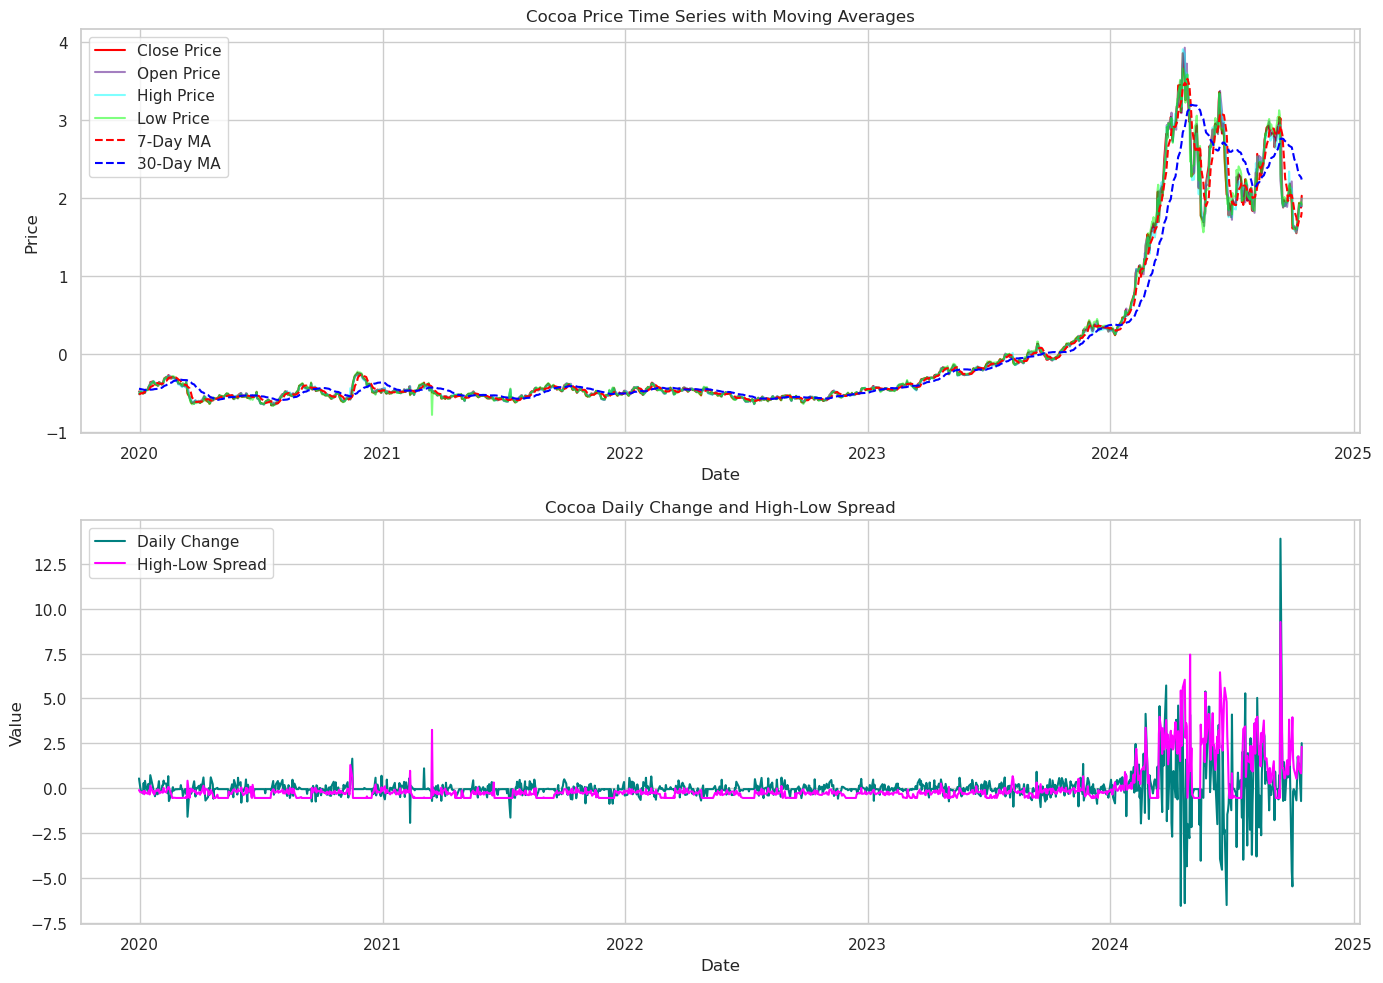

In [63]:
import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(14, 10))

# Plotting price time series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(cocoa_df['Date'], cocoa_df['Close'], label='Close Price', color='red')
plt.plot(cocoa_df['Date'], cocoa_df['Open'], label='Open Price', color='indigo', alpha=0.5)
plt.plot(cocoa_df['Date'], cocoa_df['High'], label='High Price', color='aqua', alpha=0.5)
plt.plot(cocoa_df['Date'], cocoa_df['Low'], label='Low Price', color='lime', alpha=0.5)
plt.plot(cocoa_df['Date'], cocoa_df['MA_7'], label='7-Day MA', color='red', linestyle='--')
plt.plot(cocoa_df['Date'], cocoa_df['MA_30'], label='30-Day MA', color='blue', linestyle='--')

# Adding labels and title
plt.title('Cocoa Price Time Series with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plotting Daily Change and High-Low Spread
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(cocoa_df['Date'], cocoa_df['Daily_Change'], label='Daily Change', color='teal')
plt.plot(cocoa_df['Date'], cocoa_df['High_Low_Spread'], label='High-Low Spread', color='magenta')
plt.title('Cocoa Daily Change and High-Low Spread')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

- **Cocoa Price Time Series with Moving Averages** (Top Plot)
  - Trend: The plot shows a significant upward trend starting around early 2023, with cocoa prices rising sharply. This may align with external market events or supply chain disruptions affecting cocoa prices.
  - Moving Averages: Both the 7-day and 30-day moving averages follow the trend closely, providing a smoothed view of the price data. The 30-day MA appears to capture longer-term trends, while the 7-day MA shows shorter-term fluctuations.
Volatility: The volatility increases noticeably in 2023-2024, as indicated by the fluctuations around the moving averages.

- **Cocoa Daily Change and High-Low Spread** (Bottom Plot)
   - Daily Change: There is a noticeable increase in daily price change variability, especially around 2023-2024. These fluctuations may be due to market volatility or high trading activity during that period.
   - High-Low Spread: This metric shows periods of high spread, which may indicate days of price instability or increased market activity.
   - Extreme Values: Both daily changes and high-low spreads show some extreme values, which may correspond to significant market events, potentially impacting trading strategies or risk management.

- **Conclusion**
  - These plots highlight a period of high volatility and increasing prices starting from early 2023. This information could be critical for the forecasting models, as the increased volatility may affect model accuracy as well.
  - Using models that can capture non-linear trends, such as ARIMAX or LSTM, may be beneficial given the price and volatility spikes observed.
    
(Islam, 2024)

### Smoothing:
- Using moving averages (like the 'MA_7', 'MA_30' and 'Close' columns we have calculated) allows to smooth out daily variations and highlight trends.

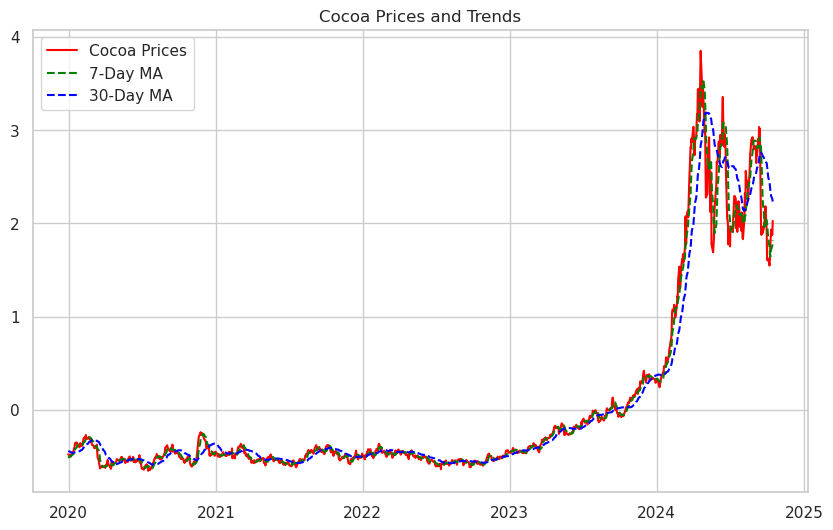

In [64]:
import matplotlib.pyplot as plt

# Plotting the prices with moving averages
plt.figure(figsize=(10,6))
plt.plot(cocoa_df['Date'], cocoa_df['Close'], label='Cocoa Prices', color='red')
plt.plot(cocoa_df['Date'], cocoa_df['MA_7'], label='7-Day MA', color='green', linestyle='--')
plt.plot(cocoa_df['Date'], cocoa_df['MA_30'], label='30-Day MA', color='blue', linestyle='--')
plt.title('Cocoa Prices and Trends')
plt.legend()
plt.show()

**Here's a brief analysis based on what we see in this plot**:

- Overall Trend: The sharp increase in cocoa prices around 2023–2024 is quite prominent. This indicates a period of high volatility, likely due to significant market changes or events affecting cocoa prices.

- Moving Averages (MA):

The 7-day MA (green dashed line) provides a smoother trend than the daily prices but still reacts quickly to price changes. This makes it useful for observing short-term trends while filtering out noise.
The 30-day MA (blue dashed line) is even smoother and lags behind the daily prices and the 7-day MA. It's better suited for understanding long-term trends and can help to identify sustained price directions.

- Insights for Forecasting:

When using these moving averages as features in forecasting models, they can provide additional information about the trend direction and help to stabilize predictions during high volatility.
For models like ARIMA or ARIMAX, incorporating a moving average as an exogenous variable could help capture underlying trends that may not be immediately obvious from the raw daily prices alone.

### Seasonality </br>
Seasonality refers to cyclical variations that occur at regular intervals in time series data. In the case of cocoa, this could correspond to fluctuations related to harvest periods or economic events.

We will use time series decomposition to separate the trend, seasonality, and noise.

(Islam, 2024)

In [65]:
#!pip install statsmodels 

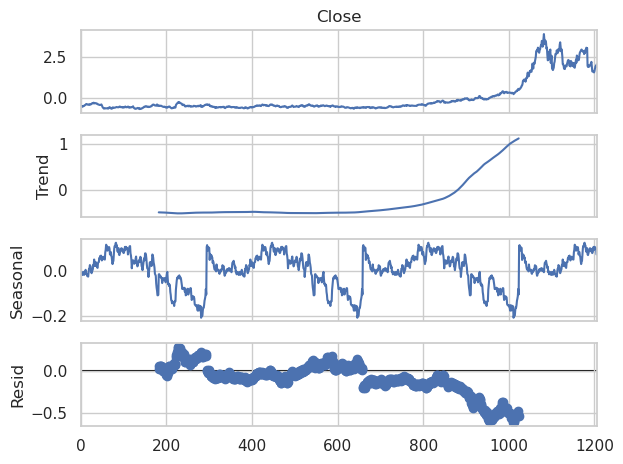

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(cocoa_df['Close'], model='additive', period=365)  # Adjust 'period' based on the dataset

# Visualize the components
decomposition.plot()
plt.show()

**Here's the analysis of the different components in the plot**:

- Observed (Top Plot):

This shows the original time series data of the "Close" prices.
There is a clear upward trend in prices over time, especially notable in the later part of the series (near 2024), followed by some fluctuations.

- Trend (Second Plot):

The trend component captures the overall long-term movement in cocoa prices.
The upward trend is clearly visible here, especially as prices rise steeply towards the end of the time series.
This trend information is valuable for forecasting, as it indicates a sustained increase over time, likely influenced by market factors impacting cocoa prices.

- Seasonal (Third Plot):

The seasonal component shows repeating patterns or cycles within each period.
This plot indicates that there is some seasonal variation in the cocoa prices, though it may not be very pronounced.
This component is useful for understanding periodic patterns, which could help improve forecast accuracy if these patterns are consistent over time.

- Residuals (Bottom Plot):

The residuals represent the "noise" or unexplained variations after accounting for the trend and seasonal components.
Ideally, residuals should be centered around zero without any discernible pattern, which indicates that the model has captured most of the information in the time series.
However, it looks like there may be some structure in the residuals, especially towards the end of the series, which suggests that there could be additional factors influencing price changes not captured by this decomposition.

### Detecting anomalies
Anomalies are data points that deviate radically from other observations, which could indicate an exceptional event (economic crisis, supply problems, etc.).

We will use simple statistical methods such as Z-score to detect these anomalies.

(Islam, 2024)

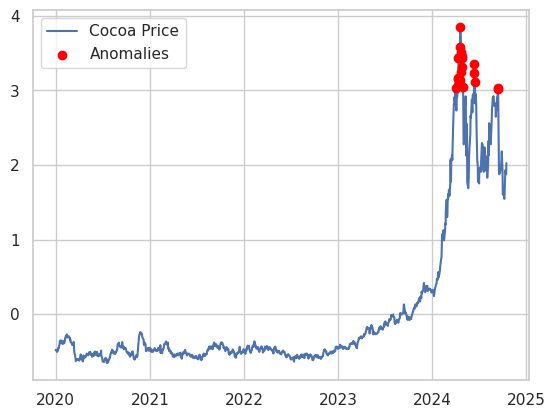

In [67]:
from scipy import stats

# Calculate Z-score to detect anomalies
cocoa_df['Z_score'] = stats.zscore(cocoa_df['Close'])

# Detect anomalies (e.g. Z-score > 3 or < -3)
anomalies = cocoa_df[(cocoa_df['Z_score'] > 3) | (cocoa_df['Z_score'] < -3)]
plt.plot(cocoa_df['Date'], cocoa_df['Close'], label='Cocoa Price')
plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.show()

- We identified a number of anomalies in 2024. These anomalies align with real-world events. They are caused by external significant factors.
- **Investigation of the Cause**: The price of a tonne of cocoa soared to a peak of $12,261 on April 19, 2024 on the New York Stock Exchange, an increase of over 190% year-on-year. This trend on the stock markets is partly explained by the significant drop in production (14.2% over the 2023-2024 season) worldwide (ICCO), particularly in Côte d'Ivoire and Ghana, the two main cocoa-producing countries. This drop is directly linked to the consequences of global warming on cocoa plantations: the El Niño phenomenon, cocoa tree diseases, excessive bad weather, etc. (La Tribune, 2024)
- **The anomalies representing genuine events, we will keep them for a more realistic model**.

### <span id="top10">2. ARIMA model construction and parameter fitting</span>

### Introduction to ARIMA
The ARIMA (AutoRegressive Integrated Moving Average) model is one of the most widely used models for predicting time series. It is composed of three parameters:
- p: The number of autoregressive (AR) terms.
- d: The number of differences required to make the series stationary (I for “Integrated”).
- q: The number of moving-average terms (MA).
### Making the series stationary 
Before building an ARIMA model, it's essential that the series is stationary (i.e. its statistical properties don't change over time). </br>
We'll use the Dickey-Fuller test to check whether our series is stationary. If it isn't, we'll apply differentiation (d).

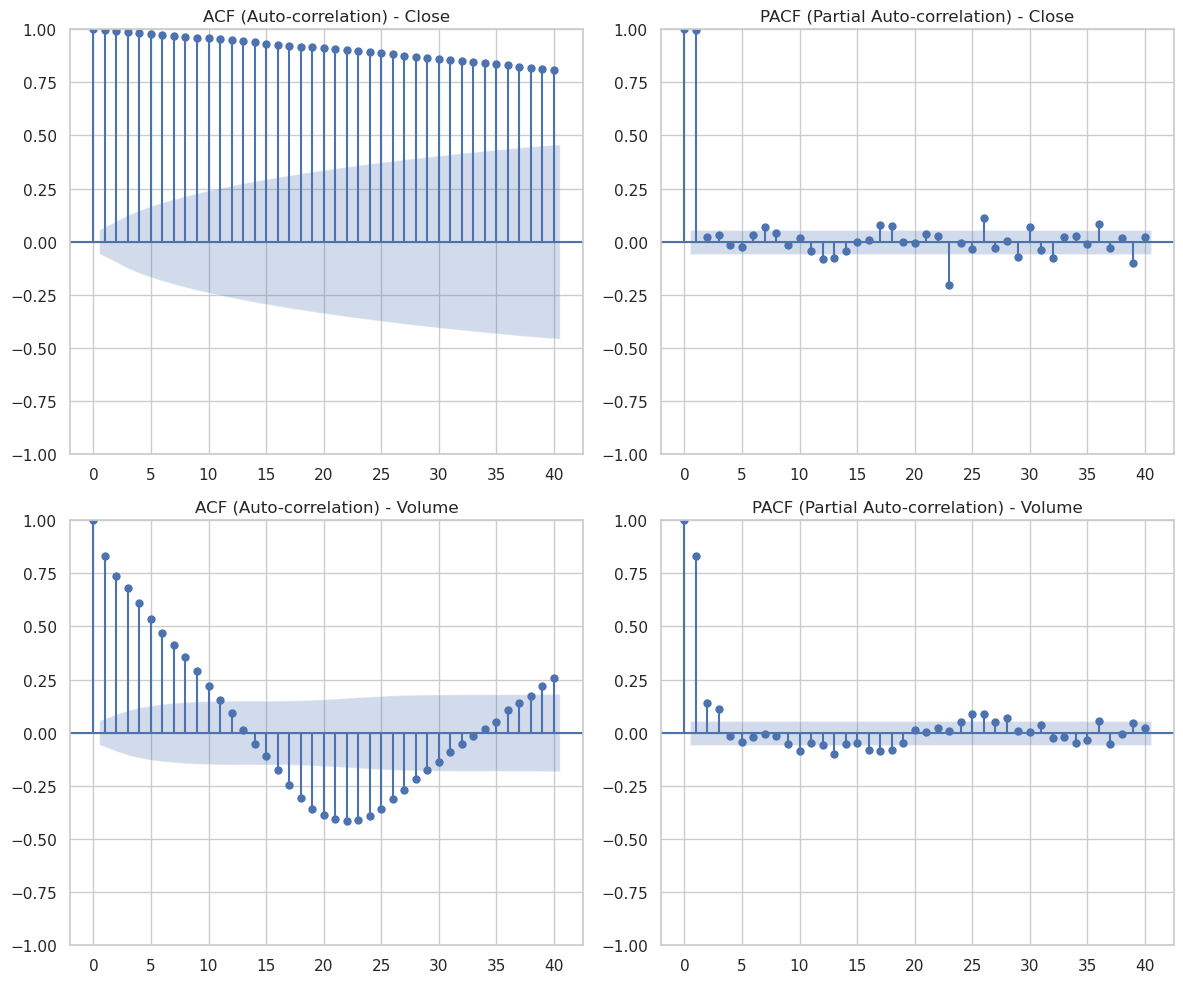

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt

# Plot ACF and PACF for the 'Close' and 'Volume' variables
plt.figure(figsize=(12, 10))

# ACF for 'Close'
plt.subplot(2, 2, 1)
plot_acf(cocoa_df['Close'].dropna(), lags=40, ax=plt.gca())
plt.title("ACF (Auto-correlation) - Close")

# PACF for 'Close'
plt.subplot(2, 2, 2)
plot_pacf(cocoa_df['Close'].dropna(), lags=40, ax=plt.gca())
plt.title("PACF (Partial Auto-correlation) - Close")

# ACF for 'Volume'
plt.subplot(2, 2, 3)
plot_acf(cocoa_df['Volume'].dropna(), lags=40, ax=plt.gca())
plt.title("ACF (Auto-correlation) - Volume")

# PACF for 'Volume'
plt.subplot(2, 2, 4)
plot_pacf(cocoa_df['Volume'].dropna(), lags=40, ax=plt.gca())
plt.title("PACF (Partial Auto-correlation) - Volume")

plt.tight_layout()
plt.show()

- The ACF for 'Close' shows a strong, slow-decaying pattern, indicating high autocorrelation across multiple lags. This pattern often suggests a non-stationary series, which may require differencing to make it stationary before using it in an ARIMA or ARIMAX model. PACF for 'Close':

- The PACF for 'Close' drops significantly after the first few lags, suggesting that a low autoregressive order (e.g., p=1) might capture much of the structure in this series once it is stationary. ACF for 'Volume':

- The ACF for 'Volume' shows a sinusoidal-like decay, possibly indicating a seasonal pattern or cyclical trend. This behavior could be due to patterns in market activity affecting volume over time. PACF for 'Volume':

- The PACF for 'Volume' decreases quickly after the first few lags, indicating that the short-term structure in volume could also be captured with a low-order autoregressive component.

(Islam, 2024)

In [69]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Dickey-Fuller test and print the results
def adf_test(series, name):
    result = adfuller(series.dropna())  # Drop NaN values before running the test
    print(f'ADF Test for {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f"Number of Lags Used: {result[2]}")
    print(f"Number of Observations Used: {result[3]}")
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print(f"{name} series is stationary.")
    else:
        print(f"{name} series is non-stationary.")
    print("\n")

# Running the ADF test on both 'Close' and 'Volume'
adf_test(cocoa_df['Close'], 'Close')
adf_test(cocoa_df['Volume'], 'Volume')

ADF Test for Close:
ADF Statistic: -0.42071059088720625
p-value: 0.906582999512944
Number of Lags Used: 17
Number of Observations Used: 1188
Critical Values:
   1%: -3.4358664022823593
   5%: -2.8639759363158124
   10%: -2.5680669397963927
Close series is non-stationary.


ADF Test for Volume:
ADF Statistic: -10.870602818932248
p-value: 1.3716072828278302e-19
Number of Lags Used: 18
Number of Observations Used: 1187
Critical Values:
   1%: -3.4358710597388042
   5%: -2.863977991064458
   10%: -2.5680680340944337
Volume series is stationary.




Close series is **Non-Stationary**, we will apply differentiation (d)

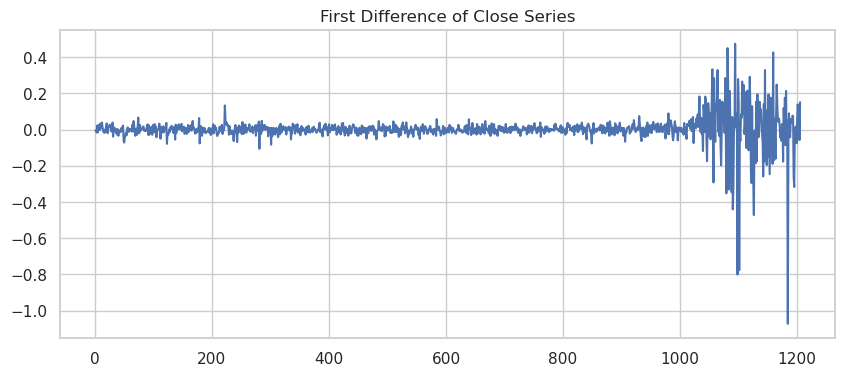

ADF Test for Differenced Close Series:
ADF Statistic: -9.33107228349651
p-value: 9.325480944209927e-16
Critical Values:
   1%: -3.4358664022823593
   5%: -2.8639759363158124
   10%: -2.5680669397963927


In [70]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Calculate the first difference of the Close series
cocoa_df['Close_diff'] = cocoa_df['Close'].diff()

# Drop NaN values created by differencing
cocoa_df['Close_diff'] = cocoa_df['Close_diff'].dropna()

# Plot the first-differenced series
plt.figure(figsize=(10, 4))
plt.plot(cocoa_df['Close_diff'])
plt.title("First Difference of Close Series")
plt.show()

# ADF test on the differenced series
adf_result_diff = adfuller(cocoa_df['Close_diff'].dropna())
print("ADF Test for Differenced Close Series:")
print(f"ADF Statistic: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"   {key}: {value}")

- The results from the ADF test on the differenced Close series indicate that it is now stationary:
  - **ADF Statistic** : -9.33 (significantly lower than all critical values).
  - **p-value** : 9.325480944209452e-16, which is well below 0.05.
    
Since the ADF statistic is much more negative than the critical values, and the p-value is very low, we can reject the null hypothesis of non-stationarity. This confirms that the **differenced Close series** is **now stationary**.

### Adjusting ARIMA parameters
A simple method for adjusting parameters p, d, and q is to use an ACF graph (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function).

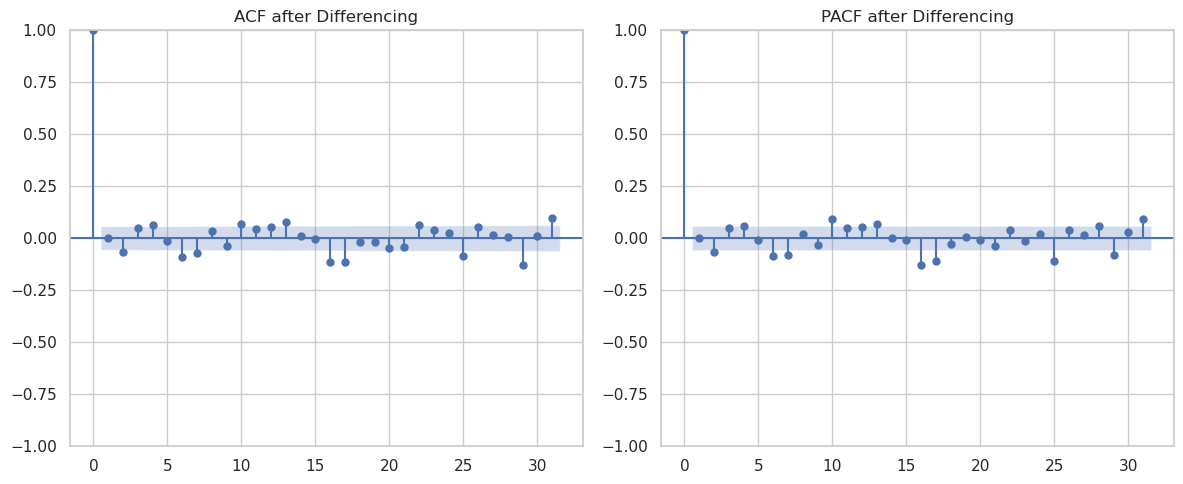

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Apply first-order differencing to 'Close' column if 'Close_diff' column does not exist
if 'Close_diff' not in cocoa_df.columns:
    cocoa_df['Close_diff'] = cocoa_df['Close'].diff()

# Drop the NaN values resulting from differencing
cocoa_df = cocoa_df.dropna(subset=['Close_diff'])

# Plot ACF and PACF for 'Close_diff'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(cocoa_df['Close_diff'], ax=axes[0])
plot_pacf(cocoa_df['Close_diff'], ax=axes[1])
axes[0].set_title('ACF after Differencing')
axes[1].set_title('PACF after Differencing')
plt.tight_layout()
plt.show()

Based on the ACF and PACF plots after differencing:

- <code>ACF Plot</code>: The ACF shows an immediate drop-off after the first lag and oscillates around zero for subsequent lags. This pattern is typical for an ARMA or ARIMA model, suggesting that any further lags contribute little to autocorrelation.

- <code>PACF Plot</code>: The PACF also shows a significant spike at lag 1, with remaining lags close to zero. This indicates that an AR(1) component could be suitable.

- Model Selection: Given these plots, **p = 1**, **d = 1** and **q = 0**. An ARIMA(1,1,0) model could be a good starting point, as the PACF suggests an AR term, while the ACF doesn't indicate a strong MA component beyond the first lag.

### ARIMA model building

In [72]:
# Count values in the 'Volume' column
volume_count = cocoa_df['Volume'].count()
print("Values in Volume:", volume_count)

# Check for NaN values in the Volume column
print("NaN values in Volume:", cocoa_df['Volume'].isna().sum())

# Check for infinite values in the Volume column
print("Infinite values in Volume:", np.isinf(cocoa_df['Volume']).sum())

Values in Volume: 1205
NaN values in Volume: 0
Infinite values in Volume: 0


In [73]:
# Display some values to look at them
cocoa_df["Volume"].tail(10)

1196    0.046100
1197   -0.022595
1198    0.174449
1199   -0.222174
1200   -0.340130
1201   -0.366154
1202   -0.402995
1203   -0.361592
1204   -0.484533
1205   -0.320442
Name: Volume, dtype: float64

- After investigation, we discovered that the NaN values are due to weekends.
- We are going to drop them.

In [74]:
# Drop rows with NaN values
cocoa_df.dropna(subset=['Volume'], inplace=True)

In [75]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Separate target and exogenous variables
close_values = cocoa_df['Close']
volume_values = cocoa_df['Volume']

# Define the ARIMAX model
arimax_model = ARIMA(close_values, order=(1, 1, 0), exog=volume_values)

# Fit the model to the data
fitted_arimax = arimax_model.fit()

# Print the model summary
print(fitted_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1205
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1340.195
Date:                Sun, 10 Nov 2024   AIC                          -2674.390
Time:                        22:56:58   BIC                          -2659.110
Sample:                             0   HQIC                         -2668.635
                               - 1205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume        -0.0011      0.008     -0.137      0.891      -0.016       0.014
ar.L1         -0.0004      0.014     -0.032      0.975      -0.027       0.026
sigma2         0.0063   5.24e-05    120.519      0.0

### <span id="top11">3. Forecasting future prices and evaluating model performance</span>

Mean Absolute Error (MAE): 0.7416839263971625
Mean Squared Error (MSE): 0.7153346317545642
Root Mean Squared Error (RMSE): 0.8457745750225436
Mean Absolute Percentage Error (MAPE): 40.42%


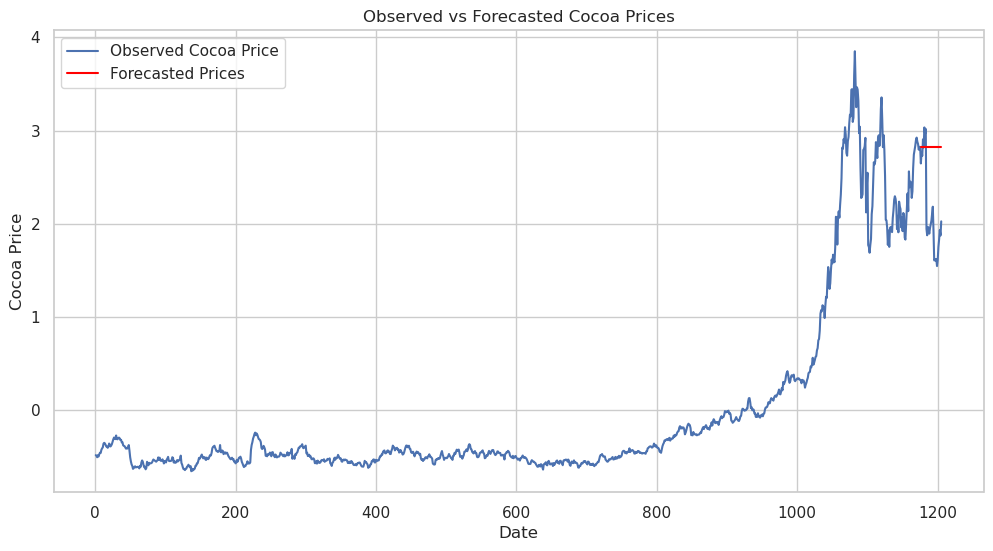

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Define the number of test steps (e.g., last 30 observations)
test_steps = 30

# Split data into train and test sets
train_data = cocoa_df.iloc[:-test_steps]
test_data = cocoa_df.iloc[-test_steps:]

# Re-train ARIMA model on the train_data (if not done already)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['Close'], order=(1, 1, 0))
fitted_model = model.fit()

# Forecast future values for the test period
forecast = fitted_model.forecast(steps=test_steps)

# Ensure there are no NaNs in `test_data` and `forecast`
test_data_close = test_data['Close'].dropna()  # Drop NaNs in test data
forecast = forecast.dropna()  # Drop NaNs in forecast

# Align forecast and test_data length if needed
min_length = min(len(test_data_close), len(forecast))
test_data_close = test_data_close.iloc[:min_length]
forecast = forecast[:min_length]

# Calculate evaluation metrics
mae = mean_absolute_error(test_data_close, forecast)
mse = mean_squared_error(test_data_close, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_data_close, forecast)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Plotting observed vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(cocoa_df.index, cocoa_df['Close'], label='Observed Cocoa Price')  # Plot full dataset
plt.plot(test_data_close.index, forecast, color='red', label='Forecasted Prices')  # Plot forecast for test period
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cocoa Price')
plt.title('Observed vs Forecasted Cocoa Prices')
plt.show()


**Error Metrics**
- Mean Absolute Error (MAE): 0.742

This indicates that, on average, the forecasted cocoa prices differ from the observed prices by around 0.742 units. This metric provides a straightforward measure of the average forecast error.

- Mean Squared Error (MSE): 0.715

The MSE penalizes larger errors more heavily, so it emphasizes significant deviations. Here, the value is reasonably low, suggesting the model doesn’t have large outliers or extreme errors.

- Root Mean Squared Error (RMSE): 0.846

The RMSE is the square root of MSE, so it’s on the same scale as the original data. An RMSE of 0.846 indicates a moderate spread of error around the true values.

- Mean Absolute Percentage Error (MAPE): 40.42%

A MAPE of 40.42% suggests that the forecasted values, on average, deviate from the actual prices by about 40%. This indicates that while the model captures the trend, there may be some room for improvement, especially in managing volatility.

**Observed vs. Forecasted Plot**

- Observed Cocoa Price (Blue Line): Shows the actual prices, with noticeable trends and volatility.
- Forecasted Prices (Red Line): The forecasted values are shown towards the end of the series. It looks just like a straight line, which does not really follow the same pattern as the blue parts of the graph that are our original cocoa price. As expected, this is a worse forecast compared to the original.

**Recommendations**

- Experiment with Multivariate Models: Including additional variables, such as market indices or economic indicators, might help improve model performance, especially if there are external factors influencing prices.

- Consider Advanced Models: Given the high MAPE, we may want to explore more complex models like neural networks (e.g., LSTM) that can capture both long-term trends and short-term fluctuations more effectively.

- Tune Model Parameters: Adjusting hyperparameters, such as including additional ARIMA terms (e.g., SARIMA for seasonality), may provide slight improvements in accuracy.

(Farzad Nobar, 2024)

### <span id="top12">4. Potential Next Steps to Improve the Model</span>

- Alternative Models: We will consider using **LSTM models** for their ability to handle time-series data with long-term dependencies, especially if price fluctuations are not captured well by linear models like ARIMAX in our case.

#### Build the LSTM model

In [79]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow

We need to prepare our data for the LSTM model. This includes normalizing the data and reshaping it into the appropriate format.

In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure 'Date' column is in datetime format
#cocoa_df['Date'] = pd.to_datetime(cocoa_df['Date'])
#cocoa_df.set_index('Date', inplace=True)

# Use the 'Close' price for forecasting
data = cocoa_df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

LSTMs require input data to be in a specific shape: [samples, time steps, features].

In [81]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30  # Look back 30 days
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Building and compiling the LSTM model.

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.4))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

Training the LSTM model with your training data.

In [83]:
# Fit the model
model.fit(X_train, y_train, epochs=300, batch_size=64, verbose=1)

Epoch 1/300
15/15 [==============================] - 5s 99ms/step - loss: 0.0010
Epoch 2/300
15/15 [==============================] - 1s 101ms/step - loss: 2.7139e-04
Epoch 3/300
15/15 [==============================] - 2s 101ms/step - loss: 1.8001e-04
Epoch 4/300
15/15 [==============================] - 1s 97ms/step - loss: 1.4357e-04
Epoch 5/300
15/15 [==============================] - 1s 98ms/step - loss: 1.4618e-04
Epoch 6/300
15/15 [==============================] - 1s 99ms/step - loss: 1.3722e-04
Epoch 7/300
15/15 [==============================] - 1s 89ms/step - loss: 1.2872e-04
Epoch 8/300
15/15 [==============================] - 1s 100ms/step - loss: 1.2797e-04
Epoch 9/300
15/15 [==============================] - 2s 101ms/step - loss: 1.3933e-04
Epoch 10/300
15/15 [==============================] - 2s 112ms/step - loss: 1.2471e-04
Epoch 11/300
15/15 [==============================] - 1s 98ms/step - loss: 1.2727e-04
Epoch 12/300
15/15 [==============================] - 1s 98ms/

Using the model to make predictions on the test data.

In [52]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate MAPE and other metrics 

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [53]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

# Inverse transform y_train and y_test to get actual values (if needed)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE for training and test sets
train_mape = mean_absolute_percentage_error(y_train_actual, train_predict)
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)

# Calculate MAE for training and test sets
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train MAPE: 0.4012880510864654
Test MAPE: 0.0926412356558456
Train MAE: 0.020362914576952957
Test MAE: 0.17263847724233003
Train RMSE: 0.02604301947501013
Test RMSE: 0.2582022462673574


**Interpretation of LSTM Model Results**
- A test MAPE under 10% is excellent, indicating that the model has a high level of accuracy when predicting unseen data. The slightly higher training MAPE suggests that the model may have generalized well, which is a good sign.
- The lower MAE on the training data and the reasonable MAE on the test data suggest the model captures trends well. However, the higher test MAE might imply occasional larger prediction errors on the test set.
- The RMSE being relatively low, especially on the training data, indicates that the model has a good fit without too many large errors, and the test RMSE is still moderate. This confirms the LSTM’s effectiveness in capturing price trends and patterns in the data.

Visualizing the predictions against the actual prices

<Figure size 1200x600 with 0 Axes>

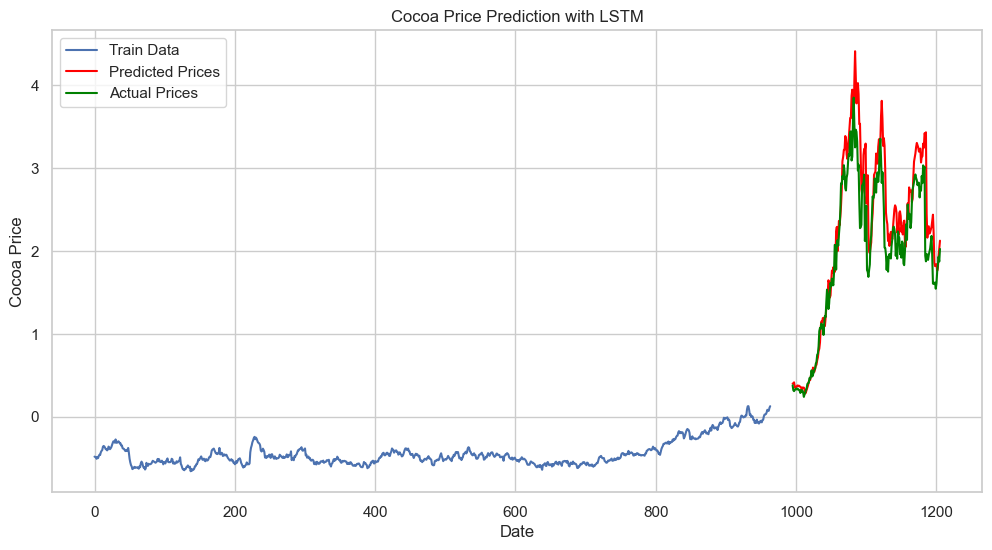

In [42]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cocoa_df.index[:train_size], data[:train_size], label='Train Data')
plt.plot(cocoa_df.index[train_size + time_step + 1:], test_predict, color='red', label='Predicted Prices')
plt.plot(cocoa_df.index[train_size + time_step + 1:], data[train_size + time_step + 1:], color='green', label='Actual Prices')
plt.title('Cocoa Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Cocoa Price')
plt.legend()
plt.show()

Based on the plot, here are some observations:

**Observed vs. Predicted Plot Analysis**

- The model seems to follow the general trend of the actual cocoa prices quite well, especially in regions with larger fluctuations.
- There are, however, some deviations where the model either overshoots or undershoots during rapid changes, which can be common in time-series predictions with LSTM.
- Train Data (Blue Line): Represents historical cocoa price data that the model was trained on.
- Actual Prices (Green Line): Shows the real price of cocoa during the test period.
- Predicted Prices (Red Line): Closely follows the actual prices, indicating that the LSTM model has been successful in tracking the actual cocoa price fluctuations.
  
The LSTM model’s performance, especially on the test set, appears strong. The low MAPE and MAE values for the test data suggest that the model can forecast cocoa prices effectively, even in the presence of volatility.

(Farzad Nobar, 2024)

### Updated Model with Fine-Tuning Options ##

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# Fit the model
model.fit(X_train, y_train, epochs=400, batch_size=64, verbose=1)

Epoch 1/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0011
Epoch 2/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 1.6098e-04
Epoch 3/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 1.1026e-04
Epoch 4/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 9.7320e-05
Epoch 5/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 1.1045e-04
Epoch 6/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 9.0115e-05
Epoch 7/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 9.5041e-05
Epoch 8/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 8.8362e-05
Epoch 9/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - loss: 1.0020e-04
Epoch 10/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 9.0355e-05
Epoch 11/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 7.6285e-05
Epoch 12/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 7.7295e-05
Epoch 13/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 7.1504e-05
Epoch 14/400
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 7

In [84]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate MAPE and other metrics 

7/7 [==============================] - 0s 20ms/step


In [87]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np

# Inverse transform y_train and y_test to get actual values (if needed)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE for training and test sets
train_mape = mean_absolute_percentage_error(y_train_actual, train_predict)
test_mape = mean_absolute_percentage_error(y_test_actual, test_predict)

# Calculate MAE for training and test sets
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)

# Calculate RMSE for training and test sets
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train MAPE: 0.169293504991383
Test MAPE: 0.08467735454739031
Train MAE: 0.016543343360375433
Test MAE: 0.16490770645850464
Train RMSE: 0.021745240663801946
Test RMSE: 0.25010515048766463


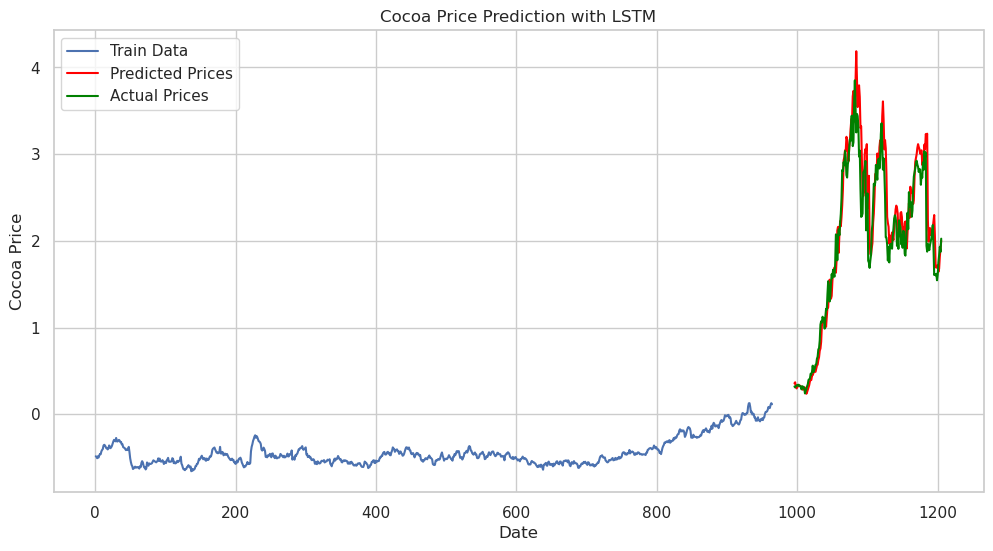

In [88]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cocoa_df.index[:train_size], data[:train_size], label='Train Data')
plt.plot(cocoa_df.index[train_size + time_step + 1:], test_predict, color='red', label='Predicted Prices')
plt.plot(cocoa_df.index[train_size + time_step + 1:], data[train_size + time_step + 1:], color='green', label='Actual Prices')
plt.title('Cocoa Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Cocoa Price')
plt.legend()
plt.show()

## <span id="top13">IV. Conclusion</span>

### <span id="top14">1. Summary of key findings</span>

The model which provided the most accurate forecasts is LTSM. It able to capture complex patterns but may struggle with highly volatile series. So it requires more computational power and time to train.

### <span id="top15">2. Discussion on the limitations of the models and suggestions for future improvements</span>

- **Fine-Tuning**: Further hyperparameter tuning (e.g., number of LSTM units, dropout rate) may further reduce errors, especially on the test set.
- **Additional Features**: If available, including other exogenous variables might improve the model’s performance and reduce errors on the test set.
- **Longer Forecasts**: Consider experimenting with forecasting over longer time horizons to evaluate how well the LSTM handles long-term trends and volatility.

**This model performs well, but it takes time to train**. 


As a difficulty, we had trouble installing scikit-learn-extra in order to run the comparison of clustering algorithms using silhouette score and Davies-Bouldin index. The system required Microsoft Visual C++ 14.0 or greater. We tried to install this Microsoft component, but it didn't solve the problem. As an alternative, we developed this part of the project in our free IBM Cloud Pak for Data account.

### Reference

- Cocoainitiative.org. (2023). Au pays du cacao: comment transformer la Côte d’Ivoire? | ICI Cocoa Initiative. [online] Available at: https://www.cocoainitiative.org/fr/centre-de-ressources/resources/au-pays-du-cacao-comment-transformer-la-cote-divoire [Accessed 30 Oct. 2024].
- La Tribune (2024). Journal économique et financier. [online] La Tribune. Available at: https://www.latribune.fr/opinions/tribunes/la-face-cachee-de-la-flambee-des-prix-du-cacao-1007467.html [Accessed 28 Oct. 2024].
- Cocoa Dec 22 (CC=F). (2022). Yahoo Finance. [online] 23 Aug. Available at: https://finance.yahoo.com/quote/CC%3DF/history/ [Accessed 31 Aug. 2022].
- Taylor, C. (2024). Comparison of Methods to Inform K-Means Clustering. [online] Medium. Available at: https://towardsdatascience.com/comparison-of-methods-to-inform-k-means-clustering-a830cdc8db50.
- Sharma, P. (2019). The Most Comprehensive Guide to K-Means Clustering You’ll Ever Need. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/.
- Islam, N. (2024). Comprehensive Guide to Time Series Data Analytics and Forecasting with Python. [online] Medium. Available at: https://medium.com/@nomannayeem/comprehensive-guide-to-time-series-data-analytics-and-forecasting-with-python-2c82de2c8517.
- Farzad Nobar (2024). Time Series — ARIMA vs. SARIMA vs. LSTM: Hands-On Tutorial. [online] Medium. Available at: https://medium.com/towards-data-science/time-series-arima-vs-sarima-vs-lstm-hands-on-tutorial-bd5630298da3 [Accessed 10 Nov. 2024].
- https://cloud.ibm.com/services/pm-20/crn%3Av1%3Abluemix%3Apublic%3Apm-20%3Aeu-gb%3Aa%2Fdb3d68439b934f0a94a23ea9ad82e550%3A4f093809-0549-4a72-90a6-7e32910e4063%3A%3A?paneId=manage

## Video recorded link

https://drive.google.com/file/d/1WsEoQUUrt0LOKwZPs2DksdmSoRyDbRu2/view?usp=sharing
